In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Loading Grounding DINO model... This may take a moment.
Model loaded successfully.
Selected random image for processing: images210.jpg

Successfully detected 2 objects:
- Found 'a medicine box' with confidence 0.6844
- Found 'a white pill a red pill' with confidence 0.4010


/tmp/ipykernel_36/438967975.py:75: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('hsv', len(unique_labels) + 1)


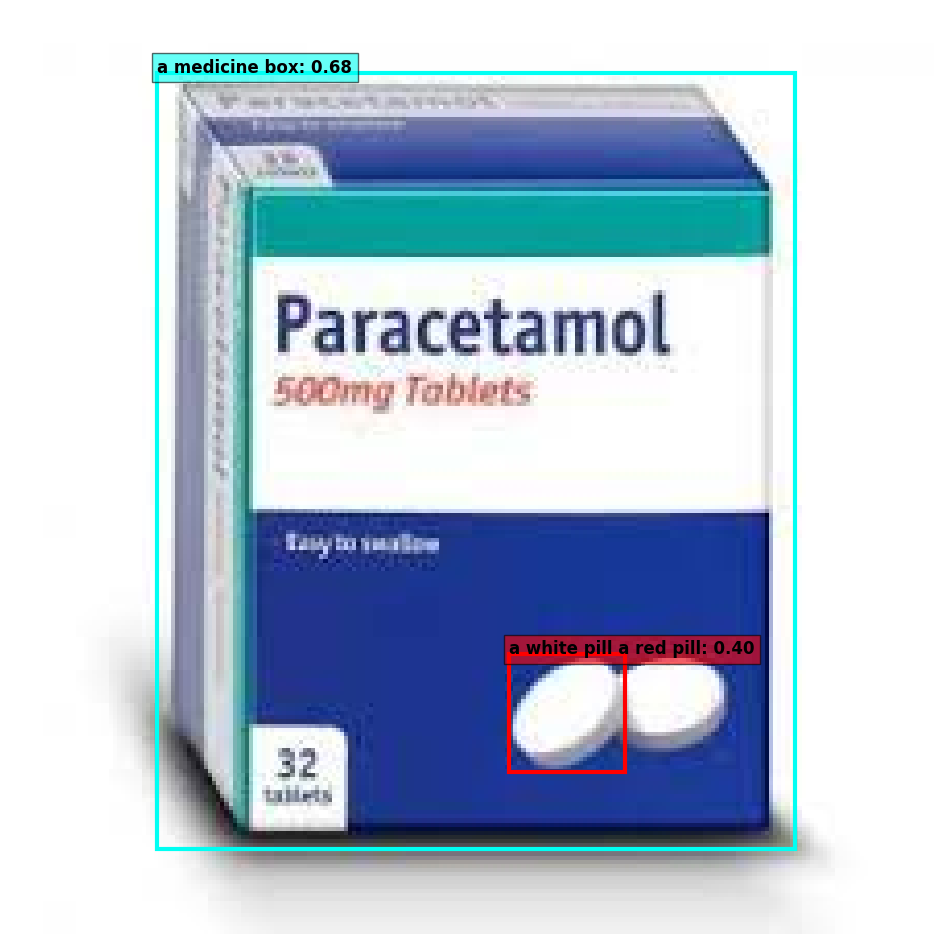

In [6]:


# Step 2: Import everything
import torch
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
from PIL import Image
import matplotlib.pyplot as plt
import os
import random

# Step 3: Load the Model and Processor from Hugging Face
# This will download the model (~1GB), so it may take a minute.
print("Loading Grounding DINO model... This may take a moment.")
model_id = "IDEA-Research/grounding-dino-base"
try:
    processor = AutoProcessor.from_pretrained(model_id)
    model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please ensure internet is enabled in your Kaggle notebook settings.")
    # Stop execution if model fails to load
    raise

# Step 4: Load a Random Sample Image from the Dataset
# The Kaggle input directory is always at ../input/
dataset_path = "/kaggle/input/medicine-tablet-pack-image-dataset/Medicine_data"
image_to_show = None
random_image_name = ""

if not os.path.exists(dataset_path) or not os.listdir(dataset_path):
    print(f"Dataset not found or empty at {dataset_path}.")
    print("Please ensure you have added the 'medicine-tablet-pack-image-dataset' via '+ Add Data'.")
else:
    image_files = [f for f in os.listdir(dataset_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not image_files:
        print("No image files were found in the dataset directory.")
    else:
        random_image_name = random.choice(image_files)
        image_path = os.path.join(dataset_path, random_image_name)
        print(f"Selected random image for processing: {random_image_name}")
        image_to_show = Image.open(image_path).convert("RGB")

# --- Only proceed if an image was successfully loaded ---
if image_to_show:
    # Step 5: Define Text Prompts and Run Inference
    # Use a '.' to separate different objects you want to detect.
    # This prompt asks the model to find pills, boxes, and text.
    text_prompt = "a white pill. a red pill. a medicine box. text on a label."

    # Process the image and text prompt
    inputs = processor(images=image_to_show, text=text_prompt, return_tensors="pt")

    # Run the model
    with torch.no_grad():
        outputs = model(**inputs)

    # Process the output to get boxes, scores, and labels
    # The target_sizes are needed to scale the boxes back to the original image size
    results = processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        box_threshold=0.4,      # Lower this to detect more objects
        text_threshold=0.3,     # Lower this to associate more labels
        target_sizes=[image_to_show.size[::-1]] # (height, width)
    )

    # Step 6: Visualize the Detection Results
    def plot_results(pil_img, scores, labels, boxes):
        """Helper function to draw bounding boxes on an image."""
        plt.figure(figsize=(20, 12))
        plt.imshow(pil_img)
        ax = plt.gca()

        # Create a color map for different labels
        unique_labels = list(set(labels))
        palette = plt.cm.get_cmap('hsv', len(unique_labels) + 1)
        colors = {label: palette(i) for i, label in enumerate(unique_labels)}

        for score, label, box in zip(scores, labels, boxes):
            color = colors[label]
            xmin, ymin, xmax, ymax = box
            
            # Draw bounding box
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                       fill=False, color=color, linewidth=3))
            
            # Format label text
            text = f'{label}: {score:0.2f}'
            
            # Draw text with a background
            ax.text(xmin, ymin, text, fontsize=12, weight='bold',
                    bbox=dict(facecolor=color, alpha=0.6))

        plt.axis('off')
        plt.show()

    # Extract the results for the first (and only) image
    scores = results[0]["scores"].tolist()
    labels = results[0]["labels"]
    boxes = results[0]["boxes"].tolist()

    if not labels:
        print("\nNo objects detected with the current thresholds.")
        print("You can try lowering the 'box_threshold' or 'text_threshold' values in the code.")
    else:
        print(f"\nSuccessfully detected {len(labels)} objects:")
        for label, score in zip(labels, scores):
             print(f"- Found '{label}' with confidence {score:.4f}")

    # Display the final image with detections
    plot_results(image_to_show, scores, labels, boxes)

else:
    print("\nSkipping model inference and visualization as no image was loaded.")

Loading EasyOCR and QA models...


Device set to use cuda:0


Models loaded successfully.

Processing Image: images207.jpg
Image resolution 220x229 is acceptable. Starting analysis.
Original image resolution: 220x229
Enhanced image resolution: 220x229 (Resolution Preserved)


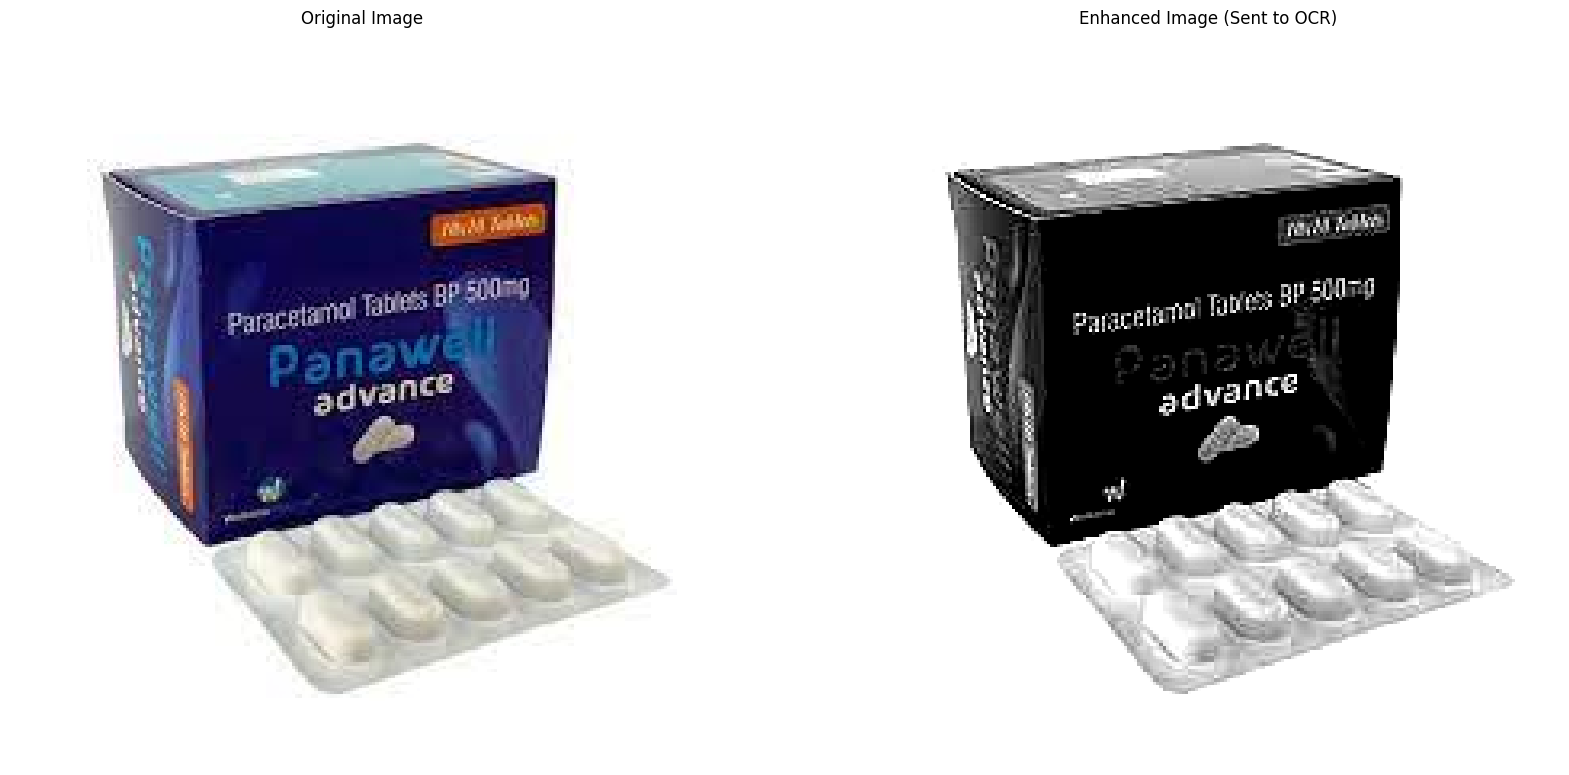


--- Running OCR...
Successfully extracted context: "M-0 Eko Famcela ^91 aovaogt"

--- Extracting Structured Information ---

--- AURA Analysis Complete ---
Brand Name: Eko Famcela (Confidence: 0.81)
Components: M-0 Eko Famcela (Confidence: 0.28)
Quantity: M-0 Eko Famcela ^91 aovaogt (Confidence: 0.28)

Visualizing final detections...


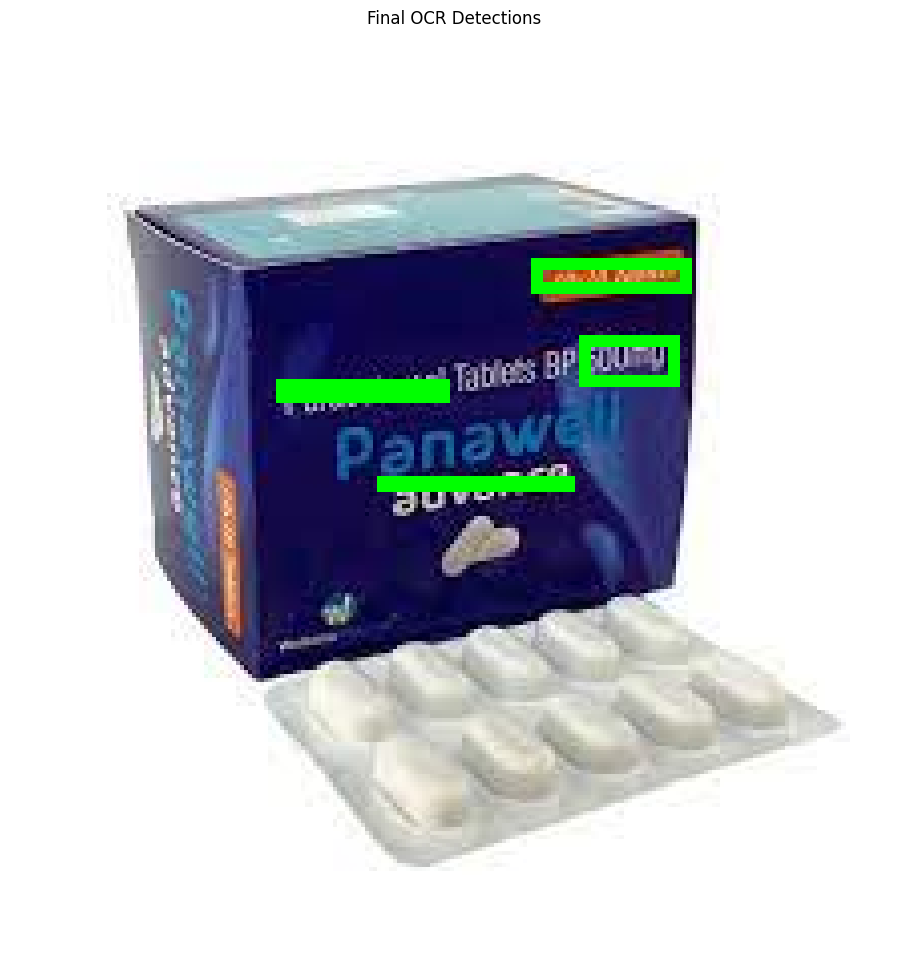

In [31]:
# Step 1: Install all required libraries

# Step 2: Import everything
import easyocr
from transformers import pipeline
from PIL import Image, ImageDraw, ImageFont, ImageEnhance
import matplotlib.pyplot as plt
import os
import random
import numpy as np

# Step 3: Load the OCR Reader and QA Model
print("Loading EasyOCR and QA models...")
try:
    reader = easyocr.Reader(['en'])
    qa_pipeline = pipeline("question-answering", model="distilbert-base-cased-distilled-squad")
    print("Models loaded successfully.")
except Exception as e:
    print(f"Error loading models: {e}")
    raise

# Step 4: Define the High-Resolution Image Enhancement Function
def enhance_for_ocr(img):
    print(f"Original image resolution: {img.size[0]}x{img.size[1]}")
    grayscale_img = img.convert('L')
    enhancer = ImageEnhance.Contrast(grayscale_img)
    contrast_img = enhancer.enhance(1.5)
    enhancer = ImageEnhance.Sharpness(contrast_img)
    sharpened_img = enhancer.enhance(2.0)
    print(f"Enhanced image resolution: {sharpened_img.size[0]}x{sharpened_img.size[1]} (Resolution Preserved)")
    return sharpened_img

# Step 5: Load a Random Sample Image
dataset_path = "/kaggle/input/medicine-tablet-pack-image-dataset/Medicine_data"
image_to_show = None
random_image_name = ""

if not os.path.exists(dataset_path):
    print(f"Dataset directory not found at: {dataset_path}")
else:
    image_files = [f for f in os.listdir(dataset_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not image_files:
        print(f"No image files found in {dataset_path}")
    else:
        random_image_name = random.choice(image_files)
        image_path = os.path.join(dataset_path, random_image_name)
        
        print(f"\n=======================================================")
        print(f"Processing Image: {random_image_name}")
        print(f"=======================================================")
        
        image_to_show = Image.open(image_path).convert("RGB")

# --- Only proceed if an image was successfully loaded ---
if image_to_show:

    # --- STEP A - PRE-COMPUTATION QUALITY FILTER ---
    MIN_RESOLUTION_THRESHOLD = 200
    width, height = image_to_show.size

    if width < MIN_RESOLUTION_THRESHOLD or height < MIN_RESOLUTION_THRESHOLD:
        print(f"IMAGE REJECTED: Resolution {width}x{height} is below the minimum threshold of {MIN_RESOLUTION_THRESHOLD}x{MIN_RESOLUTION_THRESHOLD}.")
        print("Skipping analysis for this low-quality image.")
        # Display the rejected image so we can see why
        plt.figure(figsize=(10, 7))
        plt.imshow(image_to_show)
        plt.title(f"Rejected Image: {random_image_name} ({width}x{height})")
        plt.axis('off')
        plt.show()

    else:
        # --- IF IMAGE PASSES, PROCEED WITH THE FULL PIPELINE ---
        print(f"Image resolution {width}x{height} is acceptable. Starting analysis.")
        
        # --- STEP B: ENHANCE THE IMAGE ---
        enhanced_image = enhance_for_ocr(image_to_show)

        # --- STEP C: VISUALIZE THE ENHANCEMENT ---
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.title('Original Image')
        plt.imshow(image_to_show)
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.title('Enhanced Image (Sent to OCR)')
        plt.imshow(enhanced_image, cmap='gray')
        plt.axis('off')
        plt.show()

        # --- STEP D: OCR ---
        print("\n--- Running OCR...")
        enhanced_image_np = np.array(enhanced_image)
        ocr_results = reader.readtext(enhanced_image_np)
        full_text_context = " ".join([result[1] for result in ocr_results])
        print(f"Successfully extracted context: \"{full_text_context}\"")

        # --- STEP E: INFORMATION EXTRACTION ---
        print("\n--- Extracting Structured Information ---")
        questions = { "Brand Name": "What is the brand name?", "Components": "What are the ingredients?", "Quantity": "What is the quantity?" }
        extracted_info = {}
        if not full_text_context.strip():
            print("OCR did not detect any text.")
        else:
            for key, question in questions.items():
                answer = qa_pipeline(question=question, context=full_text_context)
                extracted_info[key] = { "answer": answer['answer'].strip(), "score": round(answer['score'], 2) }

        # --- STEP F: DISPLAY RESULTS ---
        print("\n--- AURA Analysis Complete ---")
        if not extracted_info:
            print("No information could be extracted.")
        else:
            for key, value in extracted_info.items():
                print(f"{key}: {value['answer']} (Confidence: {value['score']})")

        # --- STEP G: VISUALIZATION ---
        def visualize_ocr_on_original(original_img, ocr_res):
            img_with_boxes = original_img.copy()
            draw = ImageDraw.Draw(img_with_boxes)
            for (bbox, text, prob) in ocr_res:
                (tl, tr, br, bl) = [tuple(p) for p in bbox]
                draw.rectangle([tl, br], outline="lime", width=3)
            plt.figure(figsize=(20, 12))
            plt.imshow(img_with_boxes)
            plt.title("Final OCR Detections")
            plt.axis('off')
            plt.show()

        print("\nVisualizing final detections...")
        visualize_ocr_on_original(image_to_show, ocr_results)

else:
    print("\nSkipping process as no image was loaded.")

<>:31: SyntaxWarning: invalid escape sequence '\P'
<>:88: SyntaxWarning: invalid escape sequence '\P'
<>:31: SyntaxWarning: invalid escape sequence '\P'
<>:88: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Suparno\AppData\Local\Temp\ipykernel_23760\3452119624.py:31: SyntaxWarning: invalid escape sequence '\P'
  db_path = 'D:\Programming\StatusCode2\Aura\ml\Extensive_A_Z_medicines_dataset_of_India.csv'
C:\Users\Suparno\AppData\Local\Temp\ipykernel_23760\3452119624.py:88: SyntaxWarning: invalid escape sequence '\P'
  dataset_path = "D:\Programming\StatusCode2\Aura\ml\Medicine_data\Medicine_data"


Configuring Gemini API...
Gemini Pro Vision model initialized.
Loading Extensive Medicine Knowledge Base...
Knowledge Base loaded with 256476 medicine entries.

Processing Image: images258.jpg
Image resolution 299x168 is acceptable. Sending to Gemini for extraction...

Raw Gemini Response:
```json
{
  "brand_name": "Dolo-650",
  "composition": "Paracetamol",
  "manufacturer": "N/A"
}
```


--- Starting Intelligent Search ---
Brand Name Search: Best match 'Dolo 650 Tablet' with score 100%
Composition Search: Best match 'Aceclofenac (100mg)   Paracetamol (325mg)' with score 100%

Decision: Selecting match based on Brand Name (Score: 100%)

--- AURA Analysis Complete ---
Status: High-confidence match found! (Matched on 'name')
---------------------------------------------
Verified Brand Name: Dolo 650 Tablet
Composition: Paracetamol (650mg)
Manufacturer: Micro Labs Ltd
Price (INR): 34.27
Pack Size: strip of 15 tablets
Medicine Type: allopathy
Discontinued: N/A
----------------------------

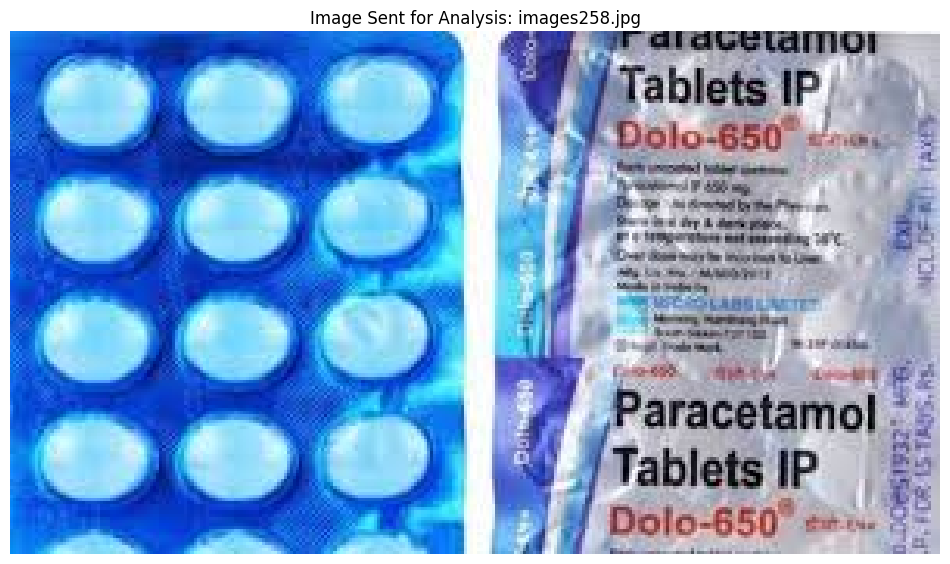

In [7]:
# Step 1: Import libraries
import google.generativeai as genai
from PIL import Image
import matplotlib.pyplot as plt
import os
import random
import json
import pandas as pd
import regex as re
from thefuzz import process, fuzz
from dotenv import load_dotenv # Import the dotenv library

# Step 2: Configure Gemini API by loading from .env file
print("Configuring Gemini API...")
try:
    load_dotenv() # Load environment variables from .env file
    api_key = os.getenv("GEMINI_API_KEY")
    if not api_key:
        raise ValueError("GEMINI_API_KEY not found. Make sure it's set in your .env file.")
    genai.configure(api_key=api_key)
    model = genai.GenerativeModel('gemini-1.5-flash-latest')
    print("Gemini Pro Vision model initialized.")
except Exception as e:
    print(f"Error configuring API or model: {e}")
    raise

# Step 3: Load and Pre-process the Extensive Knowledge Base from local path
print("Loading Extensive Medicine Knowledge Base...")
try:
    # --- IMPORTANT: Update this path to where you saved the dataset ---
    db_path = 'D:\Programming\StatusCode2\Aura\ml\Extensive_A_Z_medicines_dataset_of_India.csv'
    medicine_db = pd.read_csv(db_path)

    medicine_db['short_composition1'] = medicine_db['short_composition1'].fillna('')
    medicine_db['short_composition2'] = medicine_db['short_composition2'].fillna('')
    medicine_db['composition'] = medicine_db['short_composition1'] + ' ' + medicine_db['short_composition2']
    medicine_db['composition'] = medicine_db['composition'].str.strip()

    if 'name' in medicine_db.columns and 'composition' in medicine_db.columns:
        medicine_names = medicine_db['name'].dropna().tolist()
        medicine_compositions = medicine_db['composition'].dropna().unique().tolist()
        print(f"Knowledge Base loaded with {len(medicine_names)} medicine entries.")
    else:
        raise ValueError("'name' and/or 'composition' columns could not be created/found.")
except Exception as e:
    print(f"Error loading CSV: {e}")
    raise

# Step 4: Define the Robust Search and Intelligent Search Coordinator
def find_best_match_robustly(extracted_term, choices):
    """Performs the two-tiered search for a single term."""
    if not extracted_term or len(extracted_term) < 3:
        return None, 0

    best_match_full, score_full = process.extractOne(extracted_term, choices, scorer=fuzz.token_set_ratio)
    if score_full >= 95: return best_match_full, score_full

    primary_keyword_match = re.match(r'^[a-zA-Z]+', extracted_term)
    primary_keyword = primary_keyword_match.group(0) if primary_keyword_match else ""

    if len(primary_keyword) > 2:
        best_match_keyword, score_keyword = process.extractOne(primary_keyword, choices, scorer=fuzz.token_set_ratio)
        if score_keyword > score_full: return best_match_keyword, score_keyword

    return best_match_full, score_full

def intelligent_search(gemini_output):
    """Coordinates the dual-pronged search and returns the best overall match."""
    brand_name = gemini_output.get("brand_name")
    composition = gemini_output.get("composition")

    print("\n--- Starting Intelligent Search ---")
    best_brand_match, score_brand = find_best_match_robustly(brand_name, medicine_names)
    print(f"Brand Name Search: Best match '{best_brand_match}' with score {score_brand}%")

    best_comp_match, score_comp = find_best_match_robustly(composition, medicine_compositions)
    print(f"Composition Search: Best match '{best_comp_match}' with score {score_comp}%")

    if score_brand >= score_comp:
        print(f"\nDecision: Selecting match based on Brand Name (Score: {score_brand}%)")
        return best_brand_match, score_brand, 'name'
    else:
        print(f"\nDecision: Selecting match based on Composition (Score: {score_comp}%)")
        return best_comp_match, score_comp, 'composition'

# Step 5: Main Processing Pipeline
# --- IMPORTANT: Update this path to where you saved the image dataset ---
dataset_path = "D:\Programming\StatusCode2\Aura\ml\Medicine_data\Medicine_data"
image_files = [f for f in os.listdir(dataset_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
random_image_name = random.choice(image_files)
image_path = os.path.join(dataset_path, random_image_name)

print(f"\n=======================================================")
print(f"Processing Image: {random_image_name}")
print(f"=======================================================")

original_image = Image.open(image_path).convert("RGB")
width, height = original_image.size

if width < 150 or height < 150:
    print(f"IMAGE REJECTED: Resolution {width}x{height} is too low.")
else:
    print(f"Image resolution {width}x{height} is acceptable. Sending to Gemini for extraction...")

    try:
        prompt = """
        You are an expert pharmacy assistant. Analyze the image of the medicine packaging.
        Extract the following information and return it as a clean JSON object.
        - "brand_name": The primary brand name (e.g., "Shelcal-500", "Panawell").
        - "composition": The active ingredients (e.g., "Calcium And Vitamin D3", "Paracetamol").
        - "manufacturer": The manufacturing company (e.g., "Torrent", "Cipla").
        If any field is not visible, return "N/A". Do not include any text outside the JSON.
        """
        response = model.generate_content([prompt, original_image])
        response_text = response.text
        print(f"\nRaw Gemini Response:\n{response_text}")

        clean_json_str = response_text.strip().replace('```json', '').replace('```', '')
        gemini_data = json.loads(clean_json_str)

        if not gemini_data.get("brand_name") and not gemini_data.get("composition"):
            print("Gemini could not identify key information from the image.")
        else:
            best_match, score, match_col = intelligent_search(gemini_data)

            print("\n--- AURA Analysis Complete ---")
            if score >= 85:
                print(f"Status: High-confidence match found! (Matched on '{match_col}')")
                matched_row = medicine_db[medicine_db[match_col] == best_match].iloc[0]

                print("---------------------------------------------")
                print(f"Verified Brand Name: {matched_row.get('name', 'N/A')}")
                print(f"Composition: {matched_row.get('composition', 'N/A')}")
                print(f"Manufacturer: {matched_row.get('manufacturer_name', 'N/A')}")
                print(f"Price (INR): {matched_row.get('price(₹)', 'N/A')}")
                print(f"Pack Size: {matched_row.get('pack_size_label', 'N/A')}")
                print(f"Medicine Type: {matched_row.get('type', 'N/A')}")
                print(f"Discontinued: {matched_row.get('is_discontinued', 'N/A')}")
                print("---------------------------------------------")
            else:
                print(f"Status: Low-confidence match (Score: {score}%). The medicine could not be reliably verified.")
                print(f"The closest match found was '{best_match}'.")

    except Exception as e:
        print(f"\nAn error occurred during the process: {e}")

    # --- Visualization ---
    plt.figure(figsize=(12, 8))
    plt.imshow(original_image)
    plt.title(f"Image Sent for Analysis: {random_image_name}")
    plt.axis('off')
    plt.show()

In [4]:
# (Run this in a separate cell to see your options)
import google.generativeai as genai
from kaggle_secrets import UserSecretsClient

# Configure the API Key
api_key = UserSecretsClient().get_secret("GEMINI_API_KEY")
genai.configure(api_key=api_key)

print("Available Gemini Models:")
for model in genai.list_models():
  # Check if the model supports the 'generateContent' method
  if 'generateContent' in model.supported_generation_methods:
    print(f"- {model.name}")

Available Gemini Models:
- models/gemini-1.5-pro-latest
- models/gemini-1.5-pro-002
- models/gemini-1.5-pro
- models/gemini-1.5-flash-latest
- models/gemini-1.5-flash
- models/gemini-1.5-flash-002
- models/gemini-1.5-flash-8b
- models/gemini-1.5-flash-8b-001
- models/gemini-1.5-flash-8b-latest
- models/gemini-2.5-pro-preview-03-25
- models/gemini-2.5-flash-preview-05-20
- models/gemini-2.5-flash
- models/gemini-2.5-flash-lite-preview-06-17
- models/gemini-2.5-pro-preview-05-06
- models/gemini-2.5-pro-preview-06-05
- models/gemini-2.5-pro
- models/gemini-2.0-flash-exp
- models/gemini-2.0-flash
- models/gemini-2.0-flash-001
- models/gemini-2.0-flash-exp-image-generation
- models/gemini-2.0-flash-lite-001
- models/gemini-2.0-flash-lite
- models/gemini-2.0-flash-preview-image-generation
- models/gemini-2.0-flash-lite-preview-02-05
- models/gemini-2.0-flash-lite-preview
- models/gemini-2.0-pro-exp
- models/gemini-2.0-pro-exp-02-05
- models/gemini-exp-1206
- models/gemini-2.0-flash-thinking-

In [ ]:
# Step 1: Install necessary libraries

# Step 2: Import libraries
import google.generativeai as genai
from kaggle_secrets import UserSecretsClient
from PIL import Image
import matplotlib.pyplot as plt
import os
import random
import json
import pandas as pd
import regex as re
from thefuzz import process, fuzz

# Step 3: Configure Gemini API
print("Configuring Gemini API...")
try:
    api_key = UserSecretsClient().get_secret("GEMINI_API_KEY")
    genai.configure(api_key=api_key)
    model = genai.GenerativeModel('gemini-1.5-flash-latest')
    print("Gemini Pro Vision model initialized.")
except Exception as e:
    print(f"Error configuring API or model: {e}")
    raise

# Step 4: Load and Pre-process the Extensive Knowledge Base
print("Loading Extensive Medicine Knowledge Base...")
try:
    # Using the dataset path you have provided
    db_path = 'ml\Extensive_A_Z_medicines_dataset_of_India.csv'
    medicine_db = pd.read_csv(db_path)

    # --- NEW: Adapt to the new dataset's column structure ---
    # Fill NaN values in composition columns with empty strings
    medicine_db['short_composition1'] = medicine_db['short_composition1'].fillna('')
    medicine_db['short_composition2'] = medicine_db['short_composition2'].fillna('')
    # Create a unified 'composition' column by combining the short compositions
    medicine_db['composition'] = medicine_db['short_composition1'] + ' ' + medicine_db['short_composition2']
    # Clean up the new column by removing extra spaces
    medicine_db['composition'] = medicine_db['composition'].str.strip()

    if 'name' in medicine_db.columns and 'composition' in medicine_db.columns:
        medicine_names = medicine_db['name'].dropna().tolist()
        medicine_compositions = medicine_db['composition'].dropna().unique().tolist()
        print(f"Knowledge Base loaded with {len(medicine_names)} medicine entries.")
    else:
        raise ValueError("'name' and/or 'composition' columns could not be created/found.")
except Exception as e:
    print(f"Error loading CSV: {e}")
    raise

# Step 5: Define the Robust Search and Intelligent Search Coordinator
def find_best_match_robustly(extracted_term, choices):
    """Performs the two-tiered search for a single term."""
    if not extracted_term or len(extracted_term) < 3:
        return None, 0

    best_match_full, score_full = process.extractOne(extracted_term, choices, scorer=fuzz.token_set_ratio)
    if score_full >= 95: return best_match_full, score_full

    primary_keyword_match = re.match(r'^[a-zA-Z]+', extracted_term)
    primary_keyword = primary_keyword_match.group(0) if primary_keyword_match else ""

    if len(primary_keyword) > 2:
        best_match_keyword, score_keyword = process.extractOne(primary_keyword, choices, scorer=fuzz.token_set_ratio)
        if score_keyword > score_full: return best_match_keyword, score_keyword
            
    return best_match_full, score_full

def intelligent_search(gemini_output):
    """Coordinates the dual-pronged search and returns the best overall match."""
    brand_name = gemini_output.get("brand_name")
    composition = gemini_output.get("composition")
    
    print("\n--- Starting Intelligent Search ---")
    best_brand_match, score_brand = find_best_match_robustly(brand_name, medicine_names)
    print(f"Brand Name Search: Best match '{best_brand_match}' with score {score_brand}%")

    best_comp_match, score_comp = find_best_match_robustly(composition, medicine_compositions)
    print(f"Composition Search: Best match '{best_comp_match}' with score {score_comp}%")

    if score_brand >= score_comp:
        print(f"\nDecision: Selecting match based on Brand Name (Score: {score_brand}%)")
        return best_brand_match, score_brand, 'name'
    else:
        print(f"\nDecision: Selecting match based on Composition (Score: {score_comp}%)")
        return best_comp_match, score_comp, 'composition'

# Step 6: Main Processing Pipeline
dataset_path = "/kaggle/input/medicine-tablet-pack-image-dataset/Medicine_data"
image_files = [f for f in os.listdir(dataset_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
random_image_name = random.choice(image_files)
image_path = os.path.join(dataset_path, random_image_name)

print(f"\n=======================================================")
print(f"Processing Image: {random_image_name}")
print(f"=======================================================")

original_image = Image.open(image_path).convert("RGB")
width, height = original_image.size

if width < 150 or height < 150:
    print(f"IMAGE REJECTED: Resolution {width}x{height} is too low.")
else:
    print(f"Image resolution {width}x{height} is acceptable. Sending to Gemini for extraction...")

    try:
        prompt = """
        You are an expert pharmacy assistant. Analyze the image of the medicine packaging.
        Extract the following information and return it as a clean JSON object.
        - "brand_name": The primary brand name (e.g., "Shelcal-500", "Panawell").
        - "composition": The active ingredients (e.g., "Calcium And Vitamin D3", "Paracetamol").
        - "manufacturer": The manufacturing company (e.g., "Torrent", "Cipla").
        If any field is not visible, return "N/A". Do not include any text outside the JSON.
        """
        response = model.generate_content([prompt, original_image])
        response_text = response.text
        print(f"\nRaw Gemini Response:\n{response_text}")
        
        clean_json_str = response_text.strip().replace('```json', '').replace('```', '')
        gemini_data = json.loads(clean_json_str)

        if not gemini_data.get("brand_name") and not gemini_data.get("composition"):
            print("Gemini could not identify key information from the image.")
        else:
            best_match, score, match_col = intelligent_search(gemini_data)

            print("\n--- AURA Analysis Complete ---")
            if score >= 85:
                print(f"Status: High-confidence match found! (Matched on '{match_col}')")
                matched_row = medicine_db[medicine_db[match_col] == best_match].iloc[0]
                
                # --- UPDATED: Using the correct column names from the new dataset ---
                print("---------------------------------------------")
                print(f"Verified Brand Name: {matched_row.get('name', 'N/A')}")
                print(f"Composition: {matched_row.get('composition', 'N/A')}")
                print(f"Manufacturer: {matched_row.get('manufacturer_name', 'N/A')}")
                print(f"Price (INR): {matched_row.get('price(₹)', 'N/A')}")
                print(f"Pack Size: {matched_row.get('pack_size_label', 'N/A')}")
                print(f"Medicine Type: {matched_row.get('type', 'N/A')}")
                print(f"Discontinued: {matched_row.get('is_discontinued', 'N/A')}")
                print("---------------------------------------------")
            else:
                print(f"Status: Low-confidence match (Score: {score}%). The medicine could not be reliably verified.")
                print(f"The closest match found was '{best_match}'.")

    except Exception as e:
        print(f"\nAn error occurred during the process: {e}")

    # --- Visualization ---
    plt.figure(figsize=(12, 8))
    plt.imshow(original_image)
    plt.title(f"Image Sent for Analysis: {random_image_name}")
    plt.axis('off')
    plt.show()

ModuleNotFoundError: No module named 'kaggle_secrets'

In [49]:
# Install required libraries
!pip install -q scikit-image thefuzz

# ======================================================================================
#  Block 1: All Necessary Imports
# ======================================================================================
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from tqdm.notebook import tqdm
import time
import gc

from sklearn.model_selection import train_test_split
from skimage.draw import polygon as draw_polygon

# --- Verify GPU Availability ---
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU.")

PyTorch version: 2.6.0+cu124
CUDA available: True
Using GPU: Tesla T4


In [50]:
# ======================================================================================
#  Block 2: Parse Local COCO JSON file
# ======================================================================================
print("--- Parsing local COCO annotation file ---")

# Define the path to your dataset files based on the Kaggle input directory
base_dir = '/kaggle/input/fracture-classification-dataset/FracAtlas/'
image_dir = os.path.join(base_dir, 'images', 'Fractured')
coco_json_path = os.path.join(base_dir, "Annotations/COCO JSON/COCO_fracture_masks.json")

# This dictionary will store our processed annotations
# Format: { 'image_filename.jpg': {'width': w, 'height': h, 'polygons': [[...], ...]}, ... }
annotations_map = {}

try:
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    # 1. Create a mapping from image ID to filename and dimensions
    image_id_to_details = {
        img['id']: {
            'file_name': img['file_name'],
            'width': img['width'],
            'height': img['height']
        }
        for img in coco_data['images']
    }

    # 2. Populate the annotations_map with segmentation data
    for ann in coco_data['annotations']:
        image_id = ann['image_id']
        details = image_id_to_details.get(image_id)
        
        if details:
            filename = details['file_name']
            
            # If this is the first time we see this filename, initialize its entry
            if filename not in annotations_map:
                annotations_map[filename] = {
                    'width': details['width'],
                    'height': details['height'],
                    'polygons': []
                }
            
            # Add the segmentation polygon to the list for this image
            # The COCO format can have multiple polygons per annotation, so we extend the list
            annotations_map[filename]['polygons'].extend(ann['segmentation'])

    print(f"Successfully parsed annotations for {len(annotations_map)} images.")
    # This gets a list of all image files that have a corresponding entry in our annotation map
    annotated_image_files = [f for f in os.listdir(image_dir) if f in annotations_map]
    print(f"Found {len(annotated_image_files)} images in the folder that have annotations.")

except FileNotFoundError:
    print(f"ERROR: Could not find the JSON file at {coco_json_path}")
    raise
except Exception as e:
    print(f"An error occurred during JSON parsing: {e}")
    raise

--- Parsing local COCO annotation file ---
Successfully parsed annotations for 717 images.
Found 717 images in the folder that have annotations.



--- Verifying mask generation for a random sample ---
Selected sample: IMG0002383.jpg


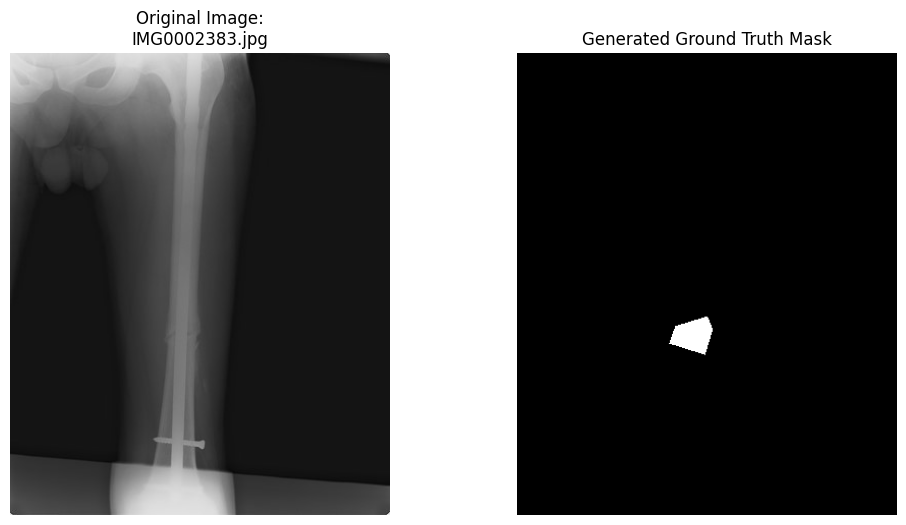

In [51]:
# ======================================================================================
#  Block 3: Polygon to Mask Conversion and Visual Verification
# ======================================================================================

def create_mask_from_polygons(image_size, polygons):
    """Converts a list of COCO-style polygons into a binary mask."""
    width, height = image_size
    mask = np.zeros((height, width), dtype=np.uint8)

    for polygon_points in polygons:
        all_x_coords = np.array(polygon_points[0::2])
        all_y_coords = np.array(polygon_points[1::2])
        rr, cc = draw_polygon(all_y_coords, all_x_coords, shape=mask.shape)
        mask[rr, cc] = 1 # Set fracture pixels to 1
        
    return mask

# --- VISUAL VERIFICATION STEP ---
print("\n--- Verifying mask generation for a random sample ---")
random_sample_filename = random.choice(annotated_image_files)
sample_image_path = os.path.join(image_dir, random_sample_filename)
sample_annotations = annotations_map[random_sample_filename]

print(f"Selected sample: {random_sample_filename}")

# Load the image
sample_image = Image.open(sample_image_path).convert("RGB")
# Generate the mask
generated_mask = create_mask_from_polygons(sample_image.size, sample_annotations['polygons'])

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title(f"Original Image:\n{random_sample_filename}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(generated_mask, cmap='gray')
plt.title("Generated Ground Truth Mask")
plt.axis('off')
plt.show()

In [52]:
# ======================================================================================
#  Block 4: Custom Dataset, Data Split, and DataLoaders
# ======================================================================================

class LocalFractureDataset(Dataset):
    """Custom PyTorch dataset for the local fracture segmentation task."""
    
    def __init__(self, image_dir, file_list, annotations, transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.file_list = file_list
        self.annotations = annotations
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        img_path = os.path.join(self.image_dir, filename)
        
        image = Image.open(img_path).convert("RGB")
        ann_data = self.annotations[filename]
        
        mask_np = create_mask_from_polygons((ann_data['width'], ann_data['height']), ann_data['polygons'])
        mask = Image.fromarray(mask_np)
        
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        mask_tensor = torch.from_numpy(np.array(mask)).long()
        
        return image, mask_tensor

# --- Split data into training and validation sets ---
train_files, val_files = train_test_split(annotated_image_files, test_size=0.15, random_state=42)
print(f"Data split: {len(train_files)} training images, {len(val_files)} validation images.")

# --- Define Transforms and DataLoaders ---
NUM_CLASSES = 2 # 0: background, 1: fracture
IMG_SIZE, IMG_MEAN, IMG_STD = (512, 512), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
BATCH_SIZE = 4

transform = T.Compose([T.Resize(IMG_SIZE), T.ToTensor(), T.Normalize(IMG_MEAN, IMG_STD)])
mask_transform = T.Compose([T.Resize(IMG_SIZE, interpolation=T.InterpolationMode.NEAREST)])

# Create Dataset and DataLoader instances
train_dataset = LocalFractureDataset(image_dir, train_files, annotations_map, transform, mask_transform)
val_dataset = LocalFractureDataset(image_dir, val_files, annotations_map, transform, mask_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
print(f"\nDataLoaders created successfully.")

Data split: 609 training images, 108 validation images.

DataLoaders created successfully.


In [53]:
# =====================================================================================
#  Block 5: Model Architecture and Training/Evaluation Functions (Reused)
# =====================================================================================

class PositionAttentionModule(nn.Module):
    def __init__(self, in_dim):
        super(PositionAttentionModule, self).__init__(); self.chanel_in = in_dim
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1)); self.softmax = nn.Softmax(dim=-1)
    def forward(self, x):
        B, C, H, W = x.size()
        proj_query = self.query_conv(x).view(B, -1, H * W).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(B, -1, H * W)
        energy = torch.bmm(proj_query, proj_key)
        attention_map = self.softmax(energy)
        proj_value = self.value_conv(x).view(B, -1, H * W)
        out = torch.bmm(proj_value, attention_map.permute(0, 2, 1))
        out = out.view(B, C, H, W); out = self.gamma * out + x
        return out

class ChannelAttentionModule(nn.Module):
    def __init__(self):
        super(ChannelAttentionModule, self).__init__()
        self.beta = nn.Parameter(torch.zeros(1)); self.softmax = nn.Softmax(dim=-1)
    def forward(self, x):
        B, C, H, W = x.size()
        proj_query = x.view(B, C, -1); proj_key = x.view(B, C, -1).permute(0, 2, 1)
        energy = torch.bmm(proj_query, proj_key); attention_map = self.softmax(energy)
        proj_value = x.view(B, C, -1); out = torch.bmm(attention_map, proj_value)
        out = out.view(B, C, H, W); out = self.beta * out + x
        return out

class DANetHead(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DANetHead, self).__init__()
        inter_channels = in_channels // 4
        self.conv5a = nn.Sequential(nn.Conv2d(in_channels, inter_channels, 3, padding=1, bias=False), nn.BatchNorm2d(inter_channels), nn.ReLU())
        self.conv5c = nn.Sequential(nn.Conv2d(in_channels, inter_channels, 3, padding=1, bias=False), nn.BatchNorm2d(inter_channels), nn.ReLU())
        self.sa = PositionAttentionModule(inter_channels); self.sc = ChannelAttentionModule()
        self.conv51 = nn.Sequential(nn.Conv2d(inter_channels, inter_channels, 3, padding=1, bias=False), nn.BatchNorm2d(inter_channels), nn.ReLU())
        self.conv52 = nn.Sequential(nn.Conv2d(inter_channels, inter_channels, 3, padding=1, bias=False), nn.BatchNorm2d(inter_channels), nn.ReLU())
        self.conv8 = nn.Sequential(nn.Dropout2d(0.1, False), nn.Conv2d(inter_channels, out_channels, 1))
    def forward(self, x):
        feat_sa = self.conv5a(x); sa_feat = self.sa(feat_sa); sa_conv = self.conv51(sa_feat)
        feat_sc = self.conv5c(x); sc_feat = self.sc(feat_sc); sc_conv = self.conv52(sc_feat)
        feat_sum = sa_conv + sc_conv; s_out = self.conv8(feat_sum)
        return s_out

class DANet(nn.Module):
    def __init__(self, num_classes, backbone='resnet50', pretrained_base=True, aux=True):
        super(DANet, self).__init__(); self.aux = aux
        weights = models.ResNet50_Weights.DEFAULT if pretrained_base else None
        resnet = models.resnet50(weights=weights); backbone_out_channels = 2048
        resnet.layer3[0].conv2.stride = (1, 1); resnet.layer3[0].downsample[0].stride = (1, 1)
        resnet.layer4[0].conv2.stride = (1, 1); resnet.layer4[0].downsample[0].stride = (1, 1)
        for i in range(len(resnet.layer4)): resnet.layer4[i].conv2.dilation = (2, 2); resnet.layer4[i].conv2.padding = (2, 2)
        self.conv1=resnet.conv1; self.bn1=resnet.bn1; self.relu=resnet.relu; self.maxpool=resnet.maxpool
        self.layer1=resnet.layer1; self.layer2=resnet.layer2; self.layer3=resnet.layer3; self.layer4=resnet.layer4
        self.head = DANetHead(backbone_out_channels, num_classes)
        if self.aux: self.aux_head = nn.Sequential(nn.Conv2d(1024, 512, 3, padding=1, bias=False), nn.BatchNorm2d(512), nn.ReLU(), nn.Dropout2d(0.1, False), nn.Conv2d(512, num_classes, 1))
    def forward(self, x):
        imsize = x.size()[2:]; x = self.conv1(x); x = self.bn1(x); x = self.relu(x); x = self.maxpool(x)
        x = self.layer1(x); x = self.layer2(x); c3 = self.layer3(x); c4 = self.layer4(c3)
        main_out = self.head(c4); main_out = F.interpolate(main_out, size=imsize, mode='bilinear', align_corners=True)
        if self.training and self.aux:
            aux_out = self.aux_head(c3); aux_out = F.interpolate(aux_out, size=imsize, mode='bilinear', align_corners=True)
            return main_out, aux_out
        return main_out

def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int(); accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

def mIoU(pred_mask, mask, smooth=1e-10, n_classes=2):
    with torch.no_grad():
        pred_mask = torch.argmax(F.softmax(pred_mask, dim=1), dim=1).contiguous().view(-1)
        mask = mask.contiguous().view(-1); iou_per_class = []
        for clas in range(n_classes):
            true_class, true_label = (pred_mask == clas), (mask == clas)
            if true_label.long().sum().item() == 0: iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()
                iou_per_class.append((intersect + smooth) / (union + smooth))
        return np.nanmean(iou_per_class)

def train_one_epoch(model, optimizer, data_loader, device, epoch, criterion):
    model.train(); epoch_loss, total_acc, total_iou = 0.0, 0.0, 0.0
    progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}", unit="batch")
    for images, masks in progress_bar:
        images, masks = images.to(device, non_blocking=True), masks.to(device, non_blocking=True)
        optimizer.zero_grad(); main_outputs, aux_outputs = model(images)
        loss = criterion(main_outputs, masks) + 0.4 * criterion(aux_outputs, masks)
        loss.backward(); optimizer.step()
        acc, iou = pixel_accuracy(main_outputs, masks), mIoU(main_outputs, masks)
        epoch_loss += loss.item(); total_acc += acc; total_iou += iou
        progress_bar.set_postfix(loss=loss.item(), acc=f"{acc:.4f}", mIoU=f"{iou:.4f}")
    return epoch_loss / len(data_loader), total_acc / len(data_loader), total_iou / len(data_loader)

def evaluate(model, data_loader, device, criterion):
    model.eval(); epoch_loss, total_acc, total_iou = 0.0, 0.0, 0.0
    with torch.no_grad():
        for images, masks in data_loader:
            images, masks = images.to(device, non_blocking=True), masks.to(device, non_blocking=True)
            outputs = model(images); loss = criterion(outputs, masks)
            epoch_loss += loss.item(); total_acc += pixel_accuracy(outputs, masks); total_iou += mIoU(outputs, masks)
    return epoch_loss / len(data_loader), total_acc / len(data_loader), total_iou / len(data_loader)

print("DANet model architecture and training functions are defined.")

DANet model architecture and training functions are defined.


In [ ]:
# =====================================================================================
#  Block 6: Fine-Tuning from a Pre-trained Model
# =====================================================================================

# --- Hyperparameters and Model Path ---
EPOCHS = 25
LEARNING_RATE = 0.005 # Using a slightly lower LR for fine-tuning is a good idea
PRETRAINED_MODEL_PATH = '/kaggle/input/danet/pytorch/default/1/danet_best_model_local_fracture.pth'
FINETUNED_MODEL_SAVE_PATH = 'danet_finetuned_model.pth' # New name for the output model

# --- 1. Instantiate the model architecture ---
# Set pretrained_base=False because we will load ALL weights, not just the backbone.
model = DANet(num_classes=NUM_CLASSES, pretrained_base=False).to(device)

# --- 2. Load the state dictionary from your specific pre-trained model file ---
# Use strict=False to ignore layers that don't match (like the final classifier if it was for a different task).
try:
    print(f"--- Loading pre-trained weights from {PRETRAINED_MODEL_PATH} ---")
    model.load_state_dict(torch.load(PRETRAINED_MODEL_PATH), strict=False)
    print("--- Pre-trained weights loaded successfully for fine-tuning. ---")
except Exception as e:
    print(f"--- Could not load pre-trained weights. Training from scratch. Error: {e} ---")
    # If loading fails, we can optionally fall back to an ImageNet backbone
    # model = DANet(num_classes=NUM_CLASSES, pretrained_base=True).to(device)

# --- 3. Initialize optimizer and scheduler ---
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

print(f"\n--- Starting Fine-Tuning on device: {device} for {EPOCHS} epochs ---")
best_iou = 0.0
history = {'train_loss': [], 'val_loss': [], 'train_iou': [], 'val_iou': []}

for epoch in range(EPOCHS):
    start_time = time.time()
    train_loss, train_acc, train_iou = train_one_epoch(model, optimizer, train_loader, device, epoch, criterion)
    val_loss, val_acc, val_iou = evaluate(model, val_loader, device, criterion)
    lr_scheduler.step()
    
    history['train_loss'].append(train_loss); history['val_loss'].append(val_loss)
    history['train_iou'].append(train_iou); history['val_iou'].append(val_iou)
    
    print(f"\nEpoch {epoch+1}/{EPOCHS} | Duration: {time.time() - start_time:.2f}s")
    print(f"  Train -> Loss: {train_loss:.4f}, mIoU: {train_iou:.4f}")
    print(f"  Valid -> Loss: {val_loss:.4f}, mIoU: {val_iou:.4f}")
    
    if val_iou >= best_iou:
        best_iou = val_iou
        torch.save(model.state_dict(), FINETUNED_MODEL_SAVE_PATH)
        print(f"  *** New best fine-tuned model saved with mIoU: {best_iou:.4f} ***")
    
    gc.collect(); torch.cuda.empty_cache()

print(f"\n----------- Fine-tuning finished! Best validation mIoU: {best_iou:.4f} -----------\\n")

# --- Plot Training History ---
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1); plt.plot(history['train_loss'], label='Train Loss'); plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss vs. Epochs'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
plt.subplot(1, 2, 2); plt.plot(history['train_iou'], label='Train mIoU'); plt.plot(history['val_iou'], label='Val mIoU')
plt.title('mIoU vs. Epochs'); plt.xlabel('Epoch'); plt.ylabel('mIoU'); plt.legend(); plt.grid(True)
plt.show()

In [22]:
# =====================================================================================
#  Block 6: Main Training Loop
# =====================================================================================

EPOCHS = 25
LEARNING_RATE = 0.001

model = DANet(num_classes=NUM_CLASSES, backbone='resnet50', pretrained_base=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

print(f"--- Starting Training on device: {device} for {EPOCHS} epochs ---")
best_iou = 0.0
history = {'train_loss': [], 'val_loss': [], 'train_iou': [], 'val_iou': []}

for epoch in range(EPOCHS):
    start_time = time.time()
    train_loss, train_acc, train_iou = train_one_epoch(model, optimizer, train_loader, device, epoch, criterion)
    val_loss, val_acc, val_iou = evaluate(model, val_loader, device, criterion)
    lr_scheduler.step()
    
    history['train_loss'].append(train_loss); history['val_loss'].append(val_loss)
    history['train_iou'].append(train_iou); history['val_iou'].append(val_iou)
    
    print(f"\nEpoch {epoch+1}/{EPOCHS} | Duration: {time.time() - start_time:.2f}s")
    print(f"  Train -> Loss: {train_loss:.4f}, mIoU: {train_iou:.4f}")
    print(f"  Valid -> Loss: {val_loss:.4f}, mIoU: {val_iou:.4f}")
    
    if val_iou >= best_iou:
        best_iou = val_iou
        torch.save(model.state_dict(), 'danet_best_model_local_fracture.pth')
        print(f"  *** New best model saved with mIoU: {best_iou:.4f} ***")
    
    gc.collect(); torch.cuda.empty_cache()

print(f"\n----------- Training finished! Best validation mIoU: {best_iou:.4f} -----------\\n")

# --- Plot Training History ---
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1); plt.plot(history['train_loss'], label='Train Loss'); plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss vs. Epochs'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
plt.subplot(1, 2, 2); plt.plot(history['train_iou'], label='Train mIoU'); plt.plot(history['val_iou'], label='Val mIoU')
plt.title('mIoU vs. Epochs'); plt.xlabel('Epoch'); plt.ylabel('mIoU'); plt.legend(); plt.grid(True)
plt.show()

--- Starting Training on device: cuda for 25 epochs ---


Epoch 1:   0%|          | 0/153 [00:00<?, ?batch/s]


Epoch 1/25 | Duration: 194.90s
  Train -> Loss: 0.0918, mIoU: 0.4906
  Valid -> Loss: 0.0176, mIoU: 0.4978
  *** New best model saved with mIoU: 0.4978 ***


Epoch 2:   0%|          | 0/153 [00:00<?, ?batch/s]


Epoch 2/25 | Duration: 199.77s
  Train -> Loss: 0.0228, mIoU: 0.5347
  Valid -> Loss: 0.0165, mIoU: 0.6122
  *** New best model saved with mIoU: 0.6122 ***


Epoch 3:   0%|          | 0/153 [00:00<?, ?batch/s]


Epoch 3/25 | Duration: 201.01s
  Train -> Loss: 0.0180, mIoU: 0.6153
  Valid -> Loss: 0.0143, mIoU: 0.6599
  *** New best model saved with mIoU: 0.6599 ***


Epoch 4:   0%|          | 0/153 [00:00<?, ?batch/s]


Epoch 4/25 | Duration: 200.40s
  Train -> Loss: 0.0144, mIoU: 0.6733
  Valid -> Loss: 0.0116, mIoU: 0.6739
  *** New best model saved with mIoU: 0.6739 ***


Epoch 5:   0%|          | 0/153 [00:00<?, ?batch/s]


Epoch 5/25 | Duration: 199.71s
  Train -> Loss: 0.0106, mIoU: 0.7404
  Valid -> Loss: 0.0116, mIoU: 0.6712


Epoch 6:   0%|          | 0/153 [00:00<?, ?batch/s]


Epoch 6/25 | Duration: 200.31s
  Train -> Loss: 0.0090, mIoU: 0.7697
  Valid -> Loss: 0.0127, mIoU: 0.6986
  *** New best model saved with mIoU: 0.6986 ***


Epoch 7:   0%|          | 0/153 [00:00<?, ?batch/s]


Epoch 7/25 | Duration: 199.93s
  Train -> Loss: 0.0086, mIoU: 0.7779
  Valid -> Loss: 0.0121, mIoU: 0.6798


Epoch 8:   0%|          | 0/153 [00:00<?, ?batch/s]


Epoch 8/25 | Duration: 200.37s
  Train -> Loss: 0.0080, mIoU: 0.7894
  Valid -> Loss: 0.0116, mIoU: 0.6731


Epoch 9:   0%|          | 0/153 [00:00<?, ?batch/s]


Epoch 9/25 | Duration: 199.75s
  Train -> Loss: 0.0070, mIoU: 0.8126
  Valid -> Loss: 0.0123, mIoU: 0.6974


Epoch 10:   0%|          | 0/153 [00:00<?, ?batch/s]


Epoch 10/25 | Duration: 200.65s
  Train -> Loss: 0.0060, mIoU: 0.8295
  Valid -> Loss: 0.0131, mIoU: 0.6914


Epoch 11:   0%|          | 0/153 [00:00<?, ?batch/s]


Epoch 11/25 | Duration: 199.72s
  Train -> Loss: 0.0052, mIoU: 0.8478
  Valid -> Loss: 0.0127, mIoU: 0.6950


Epoch 12:   0%|          | 0/153 [00:00<?, ?batch/s]


Epoch 12/25 | Duration: 200.42s
  Train -> Loss: 0.0049, mIoU: 0.8551
  Valid -> Loss: 0.0132, mIoU: 0.7034
  *** New best model saved with mIoU: 0.7034 ***


Epoch 13:   0%|          | 0/153 [00:00<?, ?batch/s]


Epoch 13/25 | Duration: 199.98s
  Train -> Loss: 0.0048, mIoU: 0.8575
  Valid -> Loss: 0.0142, mIoU: 0.6911


Epoch 14:   0%|          | 0/153 [00:00<?, ?batch/s]


Epoch 14/25 | Duration: 200.13s
  Train -> Loss: 0.0043, mIoU: 0.8724
  Valid -> Loss: 0.0151, mIoU: 0.6881


Epoch 15:   0%|          | 0/153 [00:00<?, ?batch/s]


Epoch 15/25 | Duration: 200.15s
  Train -> Loss: 0.0038, mIoU: 0.8823
  Valid -> Loss: 0.0138, mIoU: 0.6984


Epoch 16:   0%|          | 0/153 [00:00<?, ?batch/s]


Epoch 16/25 | Duration: 200.15s
  Train -> Loss: 0.0035, mIoU: 0.8919
  Valid -> Loss: 0.0139, mIoU: 0.6990


Epoch 17:   0%|          | 0/153 [00:00<?, ?batch/s]


Epoch 17/25 | Duration: 199.79s
  Train -> Loss: 0.0032, mIoU: 0.8980
  Valid -> Loss: 0.0156, mIoU: 0.6990


Epoch 18:   0%|          | 0/153 [00:00<?, ?batch/s]


Epoch 18/25 | Duration: 200.24s
  Train -> Loss: 0.0029, mIoU: 0.9060
  Valid -> Loss: 0.0160, mIoU: 0.6953


Epoch 19:   0%|          | 0/153 [00:00<?, ?batch/s]


Epoch 19/25 | Duration: 199.96s
  Train -> Loss: 0.0028, mIoU: 0.9084
  Valid -> Loss: 0.0150, mIoU: 0.7078
  *** New best model saved with mIoU: 0.7078 ***


Epoch 20:   0%|          | 0/153 [00:00<?, ?batch/s]

KeyboardInterrupt: 

In [57]:
# =====================================================================================
#  Block 6: Main Training Loop (Updated to Resume from Checkpoint)
# =====================================================================================

EPOCHS = 25
LEARNING_RATE = 0.001
CHECKPOINT_PATH = '/kaggle/input/danet/pytorch/default/1/danet_best_model_local_fracture.pth'

# --- Initialize the model ---
model = DANet(num_classes=NUM_CLASSES, backbone='resnet50', pretrained_base=True).to(device)

# --- NEW: Load weights from checkpoint if it exists ---
if os.path.exists(CHECKPOINT_PATH):
    print(f"--- Checkpoint found at '{CHECKPOINT_PATH}' ---")
    try:
        model.load_state_dict(torch.load(CHECKPOINT_PATH))
        print("--- Successfully loaded model weights. Resuming training. ---")
    except Exception as e:
        print(f"--- Error loading checkpoint: {e}. Starting training from scratch. ---")
else:
    print(f"--- No checkpoint found at '{CHECKPOINT_PATH}'. Starting training from scratch. ---")

# --- Initialize optimizer and scheduler ---
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

print(f"\n--- Starting/Resuming Training on device: {device} for {EPOCHS} epochs ---")

# We will load the best_iou from a file if we want to be perfectly robust,
# but for this purpose, just starting from 0 is fine.
# The model weights are the important part.
best_iou = 0.0 
history = {'train_loss': [], 'val_loss': [], 'train_iou': [], 'val_iou': []}

for epoch in range(EPOCHS):
    start_time = time.time()
    train_loss, train_acc, train_iou = train_one_epoch(model, optimizer, train_loader, device, epoch, criterion)
    val_loss, val_acc, val_iou = evaluate(model, val_loader, device, criterion)
    lr_scheduler.step()
    
    history['train_loss'].append(train_loss); history['val_loss'].append(val_loss)
    history['train_iou'].append(train_iou); history['val_iou'].append(val_iou)
    
    print(f"\nEpoch {epoch+1}/{EPOCHS} | Duration: {time.time() - start_time:.2f}s")
    print(f"  Train -> Loss: {train_loss:.4f}, mIoU: {train_iou:.4f}")
    print(f"  Valid -> Loss: {val_loss:.4f}, mIoU: {val_iou:.4f}")
    
    if val_iou >= best_iou:
        best_iou = val_iou
        # The model will be saved to the same path, overwriting the old best model
        torch.save(model.state_dict(), CHECKPOINT_PATH)
        print(f"  *** New best model saved with mIoU: {best_iou:.4f} ***")
    
    gc.collect(); torch.cuda.empty_cache()

print(f"\n----------- Training finished! Best validation mIoU: {best_iou:.4f} -----------\\n")

# --- Plot Training History ---
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1); plt.plot(history['train_loss'], label='Train Loss'); plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss vs. Epochs'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
plt.subplot(1, 2, 2); plt.plot(history['train_iou'], label='Train mIoU'); plt.plot(history['val_iou'], label='Val mIoU')
plt.title('mIoU vs. Epochs'); plt.xlabel('Epoch'); plt.ylabel('mIoU'); plt.legend(); plt.grid(True)
plt.show()

--- Checkpoint found at '/kaggle/input/danet/pytorch/default/1/danet_best_model_local_fracture.pth' ---
--- Successfully loaded model weights. Resuming training. ---

--- Starting/Resuming Training on device: cuda for 25 epochs ---


Epoch 1:   0%|          | 0/153 [00:00<?, ?batch/s]


Epoch 1/25 | Duration: 190.54s
  Train -> Loss: 0.0233, mIoU: 0.5679
  Valid -> Loss: 0.0143, mIoU: 0.5393


RuntimeError: File /kaggle/input/danet/pytorch/default/1/danet_best_model_local_fracture.pth cannot be opened.


--- Preparing for Inference and Visualization on the new dataset ---
Successfully loaded best model weights from '/kaggle/input/danet/pytorch/default/1/danet_best_model_local_fracture.pth'.

Fetching a batch of validation data to test...
Inference complete. Visualizing results...


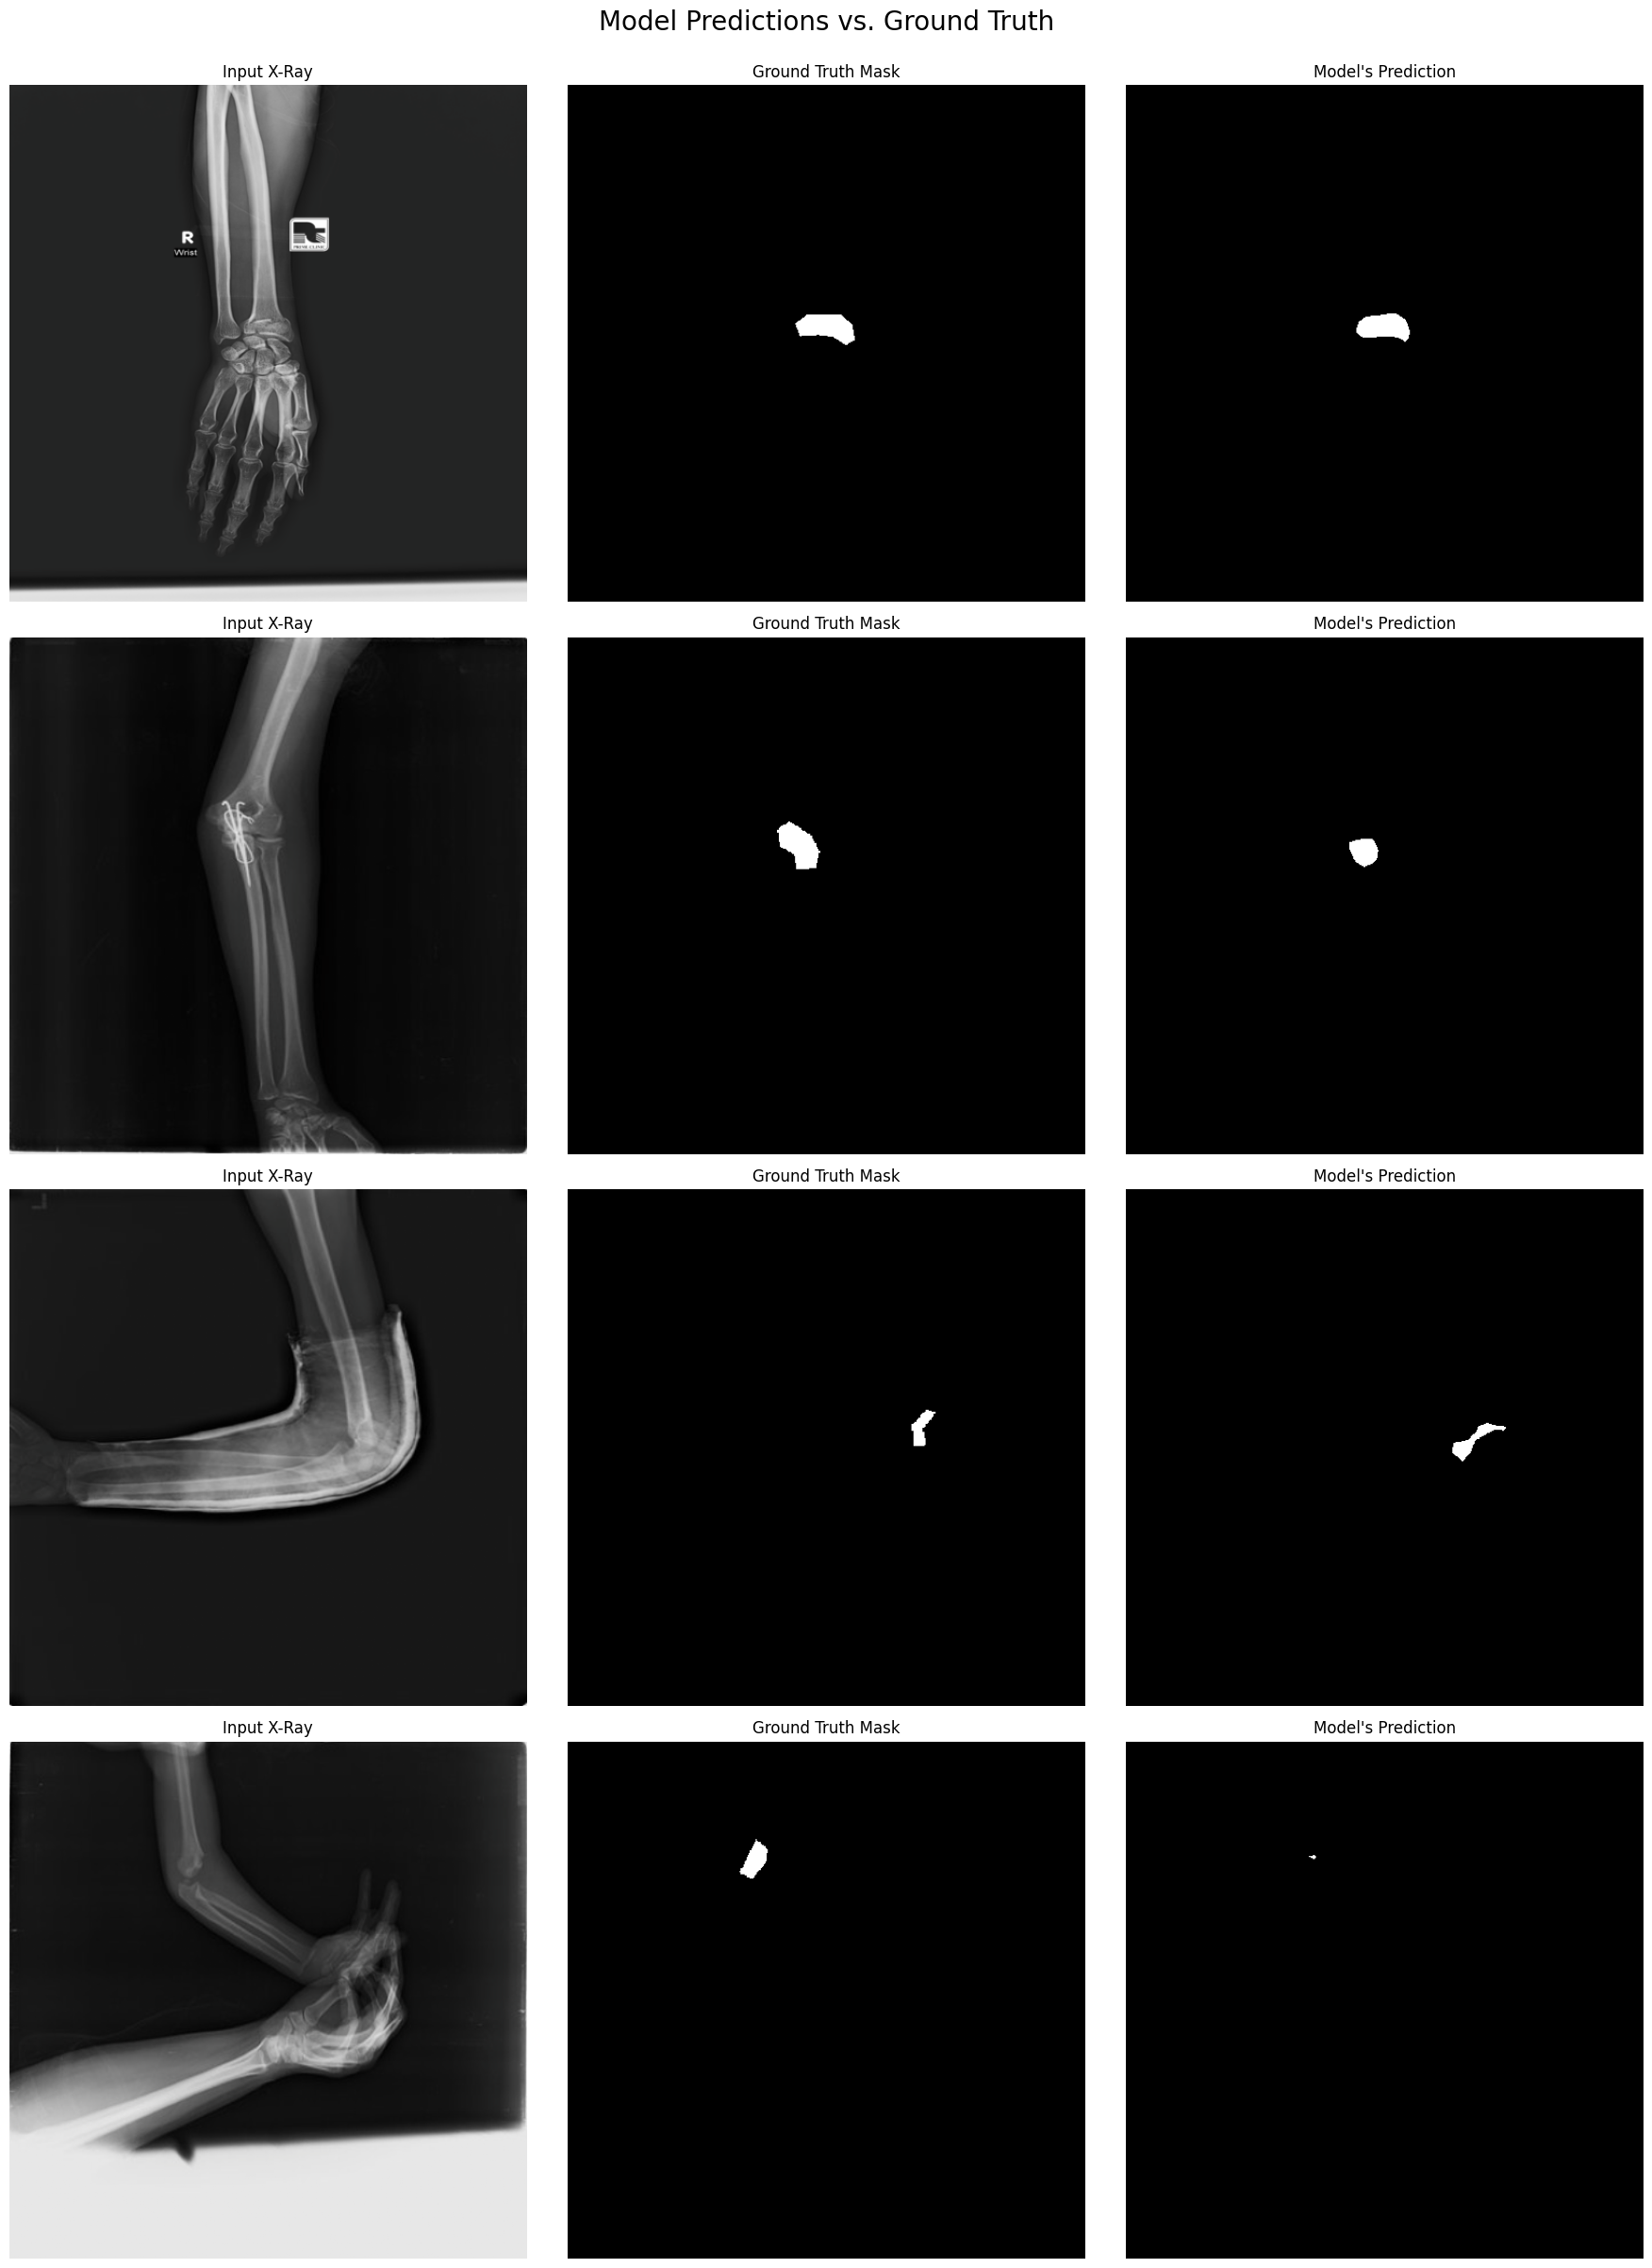

In [58]:
# =====================================================================================
#  Block 7: Inference and Visualization
# =====================================================================================

def unnormalize(tensor, mean, std):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std): t.mul_(s).add_(m)
    return tensor

print("\n--- Preparing for Inference and Visualization on the new dataset ---")
model_path = '/kaggle/input/danet/pytorch/default/1/danet_best_model_local_fracture.pth'

if not os.path.exists(model_path):
    print(f"ERROR: Model file not found at '{model_path}'. Please run the training block first.")
else:
    inference_model = DANet(num_classes=NUM_CLASSES, pretrained_base=False).to(device)
    inference_model.load_state_dict(torch.load(model_path))
    inference_model.eval()
    print(f"Successfully loaded best model weights from '{model_path}'.")

    print("\nFetching a batch of validation data to test...")
    test_images, ground_truth_masks = next(iter(val_loader))

    with torch.no_grad():
        test_images_device = test_images.to(device)
        outputs = inference_model(test_images_device)
        predictions = torch.argmax(outputs, 1).cpu()

    print("Inference complete. Visualizing results...")
    
    num_samples_to_show = min(len(test_images), 4)
    plt.figure(figsize=(18, 6 * num_samples_to_show))
    plt.suptitle("Model Predictions vs. Ground Truth", fontsize=20, y=1.0)

    for i in range(num_samples_to_show):
        img_display = unnormalize(test_images[i].cpu(), IMG_MEAN, IMG_STD).permute(1, 2, 0).numpy()
        gt_mask_display = ground_truth_masks[i].numpy()
        pred_mask_display = predictions[i].numpy()
        
        plt.subplot(num_samples_to_show, 3, i * 3 + 1)
        plt.imshow(np.clip(img_display, 0, 1))
        plt.title("Input X-Ray")
        plt.axis('off')
        
        plt.subplot(num_samples_to_show, 3, i * 3 + 2)
        plt.imshow(gt_mask_display, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')
        
        plt.subplot(num_samples_to_show, 3, i * 3 + 3)
        plt.imshow(pred_mask_display, cmap='gray')
        plt.title("Model's Prediction")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

In [63]:
# =====================================================================================
#  Block 8: Deploy Model to Hugging Face Hub (FINAL with Full Configuration)
# =====================================================================================
!pip install -q huggingface_hub

import huggingface_hub
from kaggle_secrets import UserSecretsClient
import os
import shutil

# --- 1. Log in to Hugging Face ---
try:
    HF_TOKEN = UserSecretsClient().get_secret("HF_TOKEN")
    huggingface_hub.login(token=HF_TOKEN)
    print("Successfully logged in to Hugging Face.")
except Exception as e:
    raise Exception(f"Hugging Face login failed. Please check your Kaggle Secret 'HF_TOKEN'.")

# --- 2. Define Your Model Repository (Make sure to use your actual username!) ---
repo_id = "Dojofdd/DANet-Fracture-Segmentation" 

# --- 3. Create the repository on the Hub ---
print(f"Ensuring repository '{repo_id}' exists on the Hub...")
huggingface_hub.create_repo(repo_id=repo_id, repo_type="model", exist_ok=True)
print("Repository is ready.")

# --- 4. Package Your Model Files ---
package_dir = "danet_model_package"
os.makedirs(package_dir, exist_ok=True)

# a) Copy the model weights
model_weights_path = '/kaggle/input/danet/pytorch/default/1/danet_best_model_local_fracture.pth'
destination_path = os.path.join(package_dir, "pytorch_model.bin")
if os.path.exists(model_weights_path):
    shutil.copy(model_weights_path, destination_path)
else:
    raise FileNotFoundError(f"Model weights file '{model_weights_path}' not found.")

# b) Create the model.py file (unchanged)
model_architecture_code = """
# Paste the full DANet architecture code here... (same as before)
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import models

class PositionAttentionModule(nn.Module):
    def __init__(self, in_dim):
        super(PositionAttentionModule, self).__init__(); self.chanel_in = in_dim
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1)); self.softmax = nn.Softmax(dim=-1)
    def forward(self, x):
        B, C, H, W = x.size()
        proj_query = self.query_conv(x).view(B, -1, H * W).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(B, -1, H * W)
        energy = torch.bmm(proj_query, proj_key)
        attention_map = self.softmax(energy)
        proj_value = self.value_conv(x).view(B, -1, H * W)
        out = torch.bmm(proj_value, attention_map.permute(0, 2, 1))
        out = out.view(B, C, H, W); out = self.gamma * out + x
        return out

class ChannelAttentionModule(nn.Module):
    def __init__(self):
        super(ChannelAttentionModule, self).__init__()
        self.beta = nn.Parameter(torch.zeros(1)); self.softmax = nn.Softmax(dim=-1)
    def forward(self, x):
        B, C, H, W = x.size()
        proj_query = x.view(B, C, -1); proj_key = x.view(B, C, -1).permute(0, 2, 1)
        energy = torch.bmm(proj_query, proj_key); attention_map = self.softmax(energy)
        proj_value = x.view(B, C, -1); out = torch.bmm(attention_map, proj_value)
        out = out.view(B, C, H, W); out = self.beta * out + x
        return out

class DANetHead(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DANetHead, self).__init__()
        inter_channels = in_channels // 4
        self.conv5a = nn.Sequential(nn.Conv2d(in_channels, inter_channels, 3, padding=1, bias=False), nn.BatchNorm2d(inter_channels), nn.ReLU())
        self.conv5c = nn.Sequential(nn.Conv2d(in_channels, inter_channels, 3, padding=1, bias=False), nn.BatchNorm2d(inter_channels), nn.ReLU())
        self.sa = PositionAttentionModule(inter_channels); self.sc = ChannelAttentionModule()
        self.conv51 = nn.Sequential(nn.Conv2d(inter_channels, inter_channels, 3, padding=1, bias=False), nn.BatchNorm2d(inter_channels), nn.ReLU())
        self.conv52 = nn.Sequential(nn.Conv2d(inter_channels, inter_channels, 3, padding=1, bias=False), nn.BatchNorm2d(inter_channels), nn.ReLU())
        self.conv8 = nn.Sequential(nn.Dropout2d(0.1, False), nn.Conv2d(inter_channels, out_channels, 1))
    def forward(self, x):
        feat_sa = self.conv5a(x); sa_feat = self.sa(feat_sa); sa_conv = self.conv51(sa_feat)
        feat_sc = self.conv5c(x); sc_feat = self.sc(feat_sc); sc_conv = self.conv52(sc_feat)
        feat_sum = sa_conv + sc_conv; s_out = self.conv8(feat_sum)
        return s_out

class DANet(nn.Module):
    def __init__(self, num_classes=2, backbone='resnet50', pretrained_base=False, aux=False):
        super(DANet, self).__init__(); self.aux = aux
        weights = None
        resnet = models.resnet50(weights=weights); backbone_out_channels = 2048
        resnet.layer3[0].conv2.stride = (1, 1); resnet.layer3[0].downsample[0].stride = (1, 1)
        resnet.layer4[0].conv2.stride = (1, 1); resnet.layer4[0].downsample[0].stride = (1, 1)
        for i in range(len(resnet.layer4)): resnet.layer4[i].conv2.dilation = (2, 2); resnet.layer4[i].conv2.padding = (2, 2)
        self.conv1=resnet.conv1; self.bn1=resnet.bn1; self.relu=resnet.relu; self.maxpool=resnet.maxpool
        self.layer1=resnet.layer1; self.layer2=resnet.layer2; self.layer3=resnet.layer3; self.layer4=resnet.layer4
        self.head = DANetHead(backbone_out_channels, num_classes)
    def forward(self, x):
        imsize = x.size()[2:]; x = self.conv1(x); x = self.bn1(x); x = self.relu(x); x = self.maxpool(x)
        x = self.layer1(x); x = self.layer2(x); c3 = self.layer3(x); c4 = self.layer4(c3)
        main_out = self.head(c4); main_out = F.interpolate(main_out, size=imsize, mode='bilinear', align_corners=True)
        return main_out
"""
with open(os.path.join(package_dir, "model.py"), "w") as f:
    f.write(model_architecture_code)

# c) Create the requirements.txt file (unchanged)
requirements = "torch\ntorchvision\nnumpy\nPillow"
with open(os.path.join(package_dir, "requirements.txt"), "w") as f:
    f.write(requirements)

# --- NEW: d) Create the crucial config.json file ---
config = {
  "architectures": [
    "DANet"
  ],
  "auto_map": {
    "AutoModel": "model.DANet"
  },
  "model_type": "danet"
}
with open(os.path.join(package_dir, "config.json"), "w") as f:
    json.dump(config, f, indent=2)

# --- NEW: e) Create the README.md model card ---
readme_content = """
---
license: mit
pipeline_tag: image-segmentation
---

# DANet for Fracture Segmentation

This is a DANet model with a ResNet-50 backbone, fine-tuned for segmenting bone fractures in X-ray images.

This model was trained in a Kaggle notebook as part of a hackathon project.
"""
with open(os.path.join(package_dir, "README.md"), "w") as f:
    f.write(readme_content)

# --- 5. Upload the entire package to the Hub ---
print(f"Uploading updated model package to Hugging Face Hub at: {repo_id}")
huggingface_hub.upload_folder(
    folder_path=package_dir,
    repo_id=repo_id,
    repo_type="model",
    commit_message="Add config.json and model card to enable Inference API"
)
print("Upload complete!")
print(f"You can view your deployed model at: https://huggingface.co/{repo_id}")

Successfully logged in to Hugging Face.
Ensuring repository 'Dojofdd/DANet-Fracture-Segmentation' exists on the Hub...
Repository is ready.
Uploading updated model package to Hugging Face Hub at: Dojofdd/DANet-Fracture-Segmentation
Upload complete!
You can view your deployed model at: https://huggingface.co/Dojofdd/DANet-Fracture-Segmentation


In [1]:
# Install required libraries
!pip install -q scikit-image thefuzz

# ======================================================================================
#  Block 1: All Necessary Imports
# ======================================================================================
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from tqdm.notebook import tqdm
import time
import gc

from skimage.draw import polygon as draw_polygon

# --- Verify GPU Availability ---
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 47.3 MB/s eta 0:00:00a 0:00:01
Using GPU: Tesla T4


In [2]:
# ======================================================================================
#  Block 2: Parse COCO JSON files with CORRECTED Paths
# ======================================================================================

def parse_coco(json_path, image_dir):
    """
    Parses a COCO JSON file and returns an annotation map and a list of image files.
    """
    annotations_map = {}
    
    with open(json_path, 'r') as f:
        coco_data = json.load(f)

    image_id_to_details = {img['id']: img for img in coco_data['images']}
    
    for ann in [a for a in coco_data['annotations'] if a['image_id'] in image_id_to_details]:
        image_id = ann['image_id']
        details = image_id_to_details[image_id]
        filename = details['file_name']
        
        if filename not in annotations_map:
            annotations_map[filename] = {
                'width': details['width'],
                'height': details['height'],
                'polygons': []
            }
        annotations_map[filename]['polygons'].extend(ann['segmentation'])

    annotated_image_files = [f for f in os.listdir(image_dir) if f in annotations_map]
    print(f"Parsed {json_path}: Found annotations for {len(annotated_image_files)} images.")
    return annotations_map, annotated_image_files

# --- Define Paths (CORRECTED) ---
base_dir = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/'

# --- THE FIX IS HERE ---
# Paths for the training set (using 'train' instead of 'TrainSet')
train_dir = os.path.join(base_dir, 'train')
train_json_path = os.path.join(base_dir, 'train', '_annotations.coco.json')

# Paths for the validation set (using 'valid' instead of 'ValidationSet')
valid_dir = os.path.join(base_dir, 'valid')
valid_json_path = os.path.join(base_dir, 'valid', '_annotations.coco.json')
# --- END OF FIX ---

# --- Parse both sets ---
try:
    print("--- Parsing training data ---")
    train_annotations_map, train_files = parse_coco(train_json_path, train_dir)
    print("\n--- Parsing validation data ---")
    valid_annotations_map, valid_files = parse_coco(valid_json_path, valid_dir)
except Exception as e:
    print(f"An error occurred during JSON parsing: {e}")
    raise

--- Parsing training data ---
Parsed /kaggle/input/brain-tumor-image-dataset-semantic-segmentation/train/_annotations.coco.json: Found annotations for 1501 images.

--- Parsing validation data ---
Parsed /kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid/_annotations.coco.json: Found annotations for 429 images.



--- Verifying mask generation for a random training sample ---


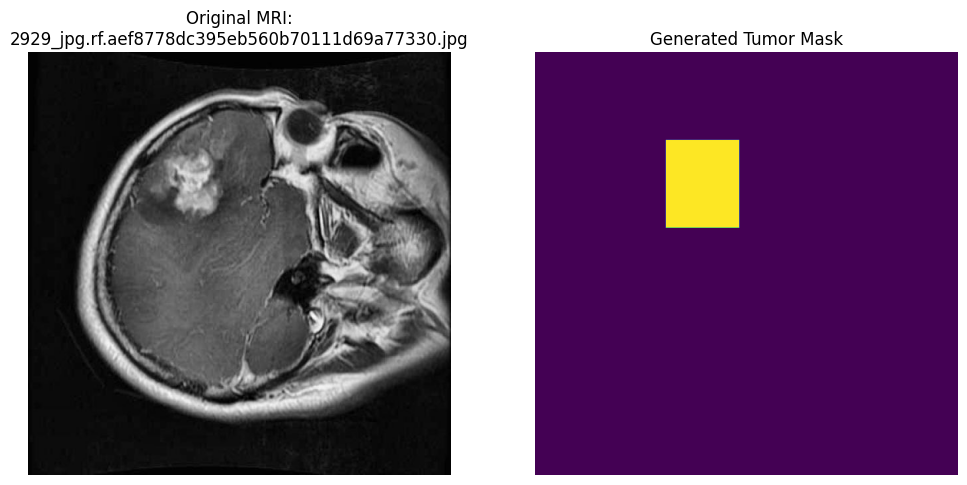

In [6]:
# ======================================================================================
#  Block 3: Polygon to Mask Conversion and Visual Verification
# ======================================================================================
import random
def create_mask_from_polygons(image_size, polygons):
    width, height = image_size
    mask = np.zeros((height, width), dtype=np.uint8)
    for polygon_points in polygons:
        all_x_coords, all_y_coords = np.array(polygon_points[0::2]), np.array(polygon_points[1::2])
        rr, cc = draw_polygon(all_y_coords, all_x_coords, shape=mask.shape)
        mask[rr, cc] = 1 # Class 1 for Tumor
    return mask

print("\n--- Verifying mask generation for a random training sample ---")
random_sample_filename = random.choice(train_files)
sample_image_path = os.path.join(train_dir, random_sample_filename)
sample_annotations = train_annotations_map[random_sample_filename]
sample_image = Image.open(sample_image_path).convert("RGB")
generated_mask = create_mask_from_polygons(sample_image.size, sample_annotations['polygons'])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1); plt.imshow(sample_image); plt.title(f"Original MRI:\n{random_sample_filename}"); plt.axis('off')
plt.subplot(1, 2, 2); plt.imshow(generated_mask, cmap='viridis'); plt.title("Generated Tumor Mask"); plt.axis('off')
plt.show()


--- Verifying mask generation for a random training sample ---
Validating with sample image: 12_jpg.rf.21eba5a77b6113c9d7f9b182092a02d3.jpg


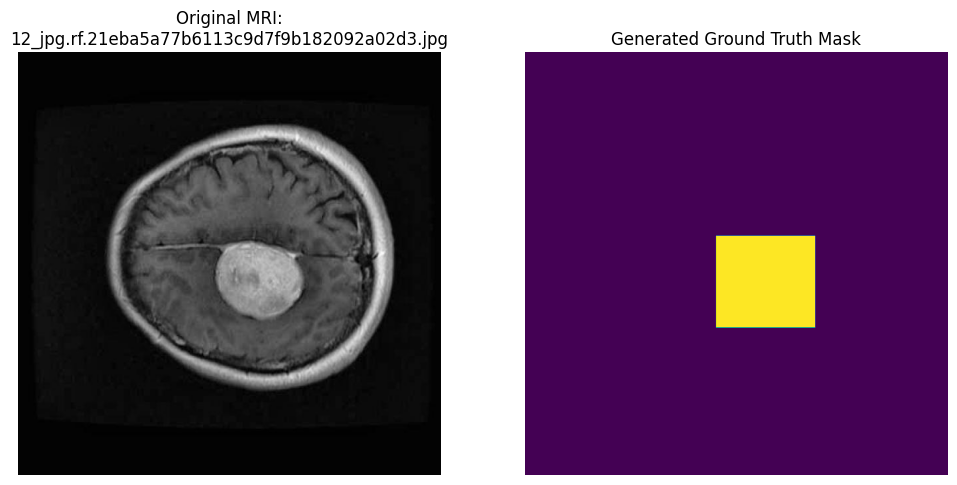

In [7]:
# ======================================================================================
#  Block 3: Polygon to Mask Conversion and Visual Verification
# ======================================================================================
from skimage.draw import polygon as draw_polygon

def create_mask_from_polygons(image_size, polygons):
    """Converts a list of COCO-style polygons into a binary mask."""
    width, height = image_size
    mask = np.zeros((height, width), dtype=np.uint8)

    for polygon_points in polygons:
        # COCO polygons are a flat list of [x1, y1, x2, y2, ...], so we slice them
        all_x_coords = np.array(polygon_points[0::2])
        all_y_coords = np.array(polygon_points[1::2])
        
        # The draw_polygon function from scikit-image fills the polygon
        rr, cc = draw_polygon(all_y_coords, all_x_coords, shape=mask.shape)
        mask[rr, cc] = 1 # Class 1 for Tumor
        
    return mask

# --- VISUAL VALIDATION STEP ---
# This is our input check. If this looks correct, we know the data pipeline is good so far.
print("\n--- Verifying mask generation for a random training sample ---")

# Select a random image filename from the list we created in Block 2
random_sample_filename = random.choice(train_files)
sample_image_path = os.path.join(train_dir, random_sample_filename)
sample_annotations = train_annotations_map[random_sample_filename]

print(f"Validating with sample image: {random_sample_filename}")

# Load the original image
sample_image = Image.open(sample_image_path).convert("RGB")

# Use our new function to generate the mask from the parsed polygon data
generated_mask = create_mask_from_polygons(sample_image.size, sample_annotations['polygons'])

# Plot the original image and our generated mask side-by-side
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title(f"Original MRI:\n{random_sample_filename}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(generated_mask, cmap='viridis') # Using a bright colormap for clear visibility
plt.title("Generated Ground Truth Mask")
plt.axis('off')
plt.show()

DataLoaders created successfully.
Training batches: 376 | Validation batches: 108

--- Validating a batch from the DataLoader ---


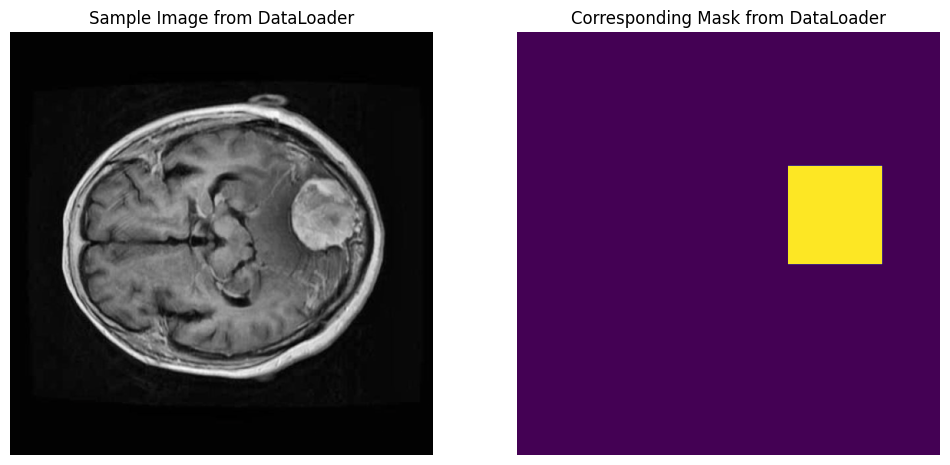

Final validation successful. The DataLoader is providing correctly paired and transformed data.


In [8]:
# ======================================================================================
#  Block 4: Custom Dataset, DataLoaders, and Final Validation
# ======================================================================================

class BrainTumorDataset(Dataset):
    """Custom PyTorch dataset for the brain tumor segmentation task."""
    
    def __init__(self, image_dir, file_list, annotations, transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.file_list = file_list
        self.annotations = annotations
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # Get the filename for the given index
        filename = self.file_list[idx]
        img_path = os.path.join(self.image_dir, filename)
        
        # Load the image
        image = Image.open(img_path).convert("RGB")
        
        # Get the corresponding annotation data
        ann_data = self.annotations[filename]
        
        # Generate the mask from the polygon data
        mask_np = create_mask_from_polygons((ann_data['width'], ann_data['height']), ann_data['polygons'])
        # Convert numpy array to PIL Image to apply transforms
        mask = Image.fromarray(mask_np)
        
        # Apply transforms if they are specified
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        # Convert the final mask to a LongTensor, which is required by the loss function
        mask_tensor = torch.from_numpy(np.array(mask)).long()
        
        return image, mask_tensor

# --- Define Transforms and Hyperparameters ---
NUM_CLASSES = 2 # 0: background, 1: tumor
# The dataset images are 640x640, but we'll resize to 512x512 for faster training and to fit GPU memory.
IMG_SIZE = (512, 512)
IMG_MEAN, IMG_STD = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225] # Standard ImageNet stats
BATCH_SIZE = 4 # Adjust this based on your GPU memory (e.g., 2, 4, 8)

# Define the image transformations: resize, convert to tensor, normalize
transform = T.Compose([
    T.Resize(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(IMG_MEAN, IMG_STD)
])

# Define the mask transformations: resize only, using nearest neighbor to preserve class labels
mask_transform = T.Compose([
    T.Resize(IMG_SIZE, interpolation=T.InterpolationMode.NEAREST)
])

# --- Create Dataset and DataLoader instances ---
train_dataset = BrainTumorDataset(train_dir, train_files, train_annotations_map, transform, mask_transform)
val_dataset = BrainTumorDataset(valid_dir, valid_files, valid_annotations_map, transform, mask_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
print(f"DataLoaders created successfully.")
print(f"Training batches: {len(train_loader)} | Validation batches: {len(val_loader)}")


# --- FINAL VISUAL VALIDATION ---
print("\n--- Validating a batch from the DataLoader ---")

# Helper function to reverse normalization for display
def unnormalize(tensor, mean, std):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

try:
    # Get one batch of data
    images, masks = next(iter(train_loader))
    
    # Display the first image and mask from the batch
    img_to_show = unnormalize(images[0], IMG_MEAN, IMG_STD).permute(1, 2, 0).cpu().numpy()
    mask_to_show = masks[0].cpu().numpy()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(np.clip(img_to_show, 0, 1)) # Clip values to be in the valid [0,1] range for display
    plt.title("Sample Image from DataLoader")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask_to_show, cmap='viridis')
    plt.title("Corresponding Mask from DataLoader")
    plt.axis('off')
    
    plt.show()
    print("Final validation successful. The DataLoader is providing correctly paired and transformed data.")
    
except Exception as e:
    print(f"Could not visualize batch. Error: {e}")

In [9]:
# =====================================================================================
#  Block 5: Model Architecture and Training/Evaluation Functions
# =====================================================================================

class PositionAttentionModule(nn.Module):
    """ Position attention module """
    def __init__(self, in_dim):
        super(PositionAttentionModule, self).__init__()
        self.chanel_in = in_dim
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)
    def forward(self, x):
        B, C, H, W = x.size()
        proj_query = self.query_conv(x).view(B, -1, H * W).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(B, -1, H * W)
        energy = torch.bmm(proj_query, proj_key)
        attention_map = self.softmax(energy)
        proj_value = self.value_conv(x).view(B, -1, H * W)
        out = torch.bmm(proj_value, attention_map.permute(0, 2, 1))
        out = out.view(B, C, H, W)
        out = self.gamma * out + x
        return out

class ChannelAttentionModule(nn.Module):
    """ Channel attention module """
    def __init__(self):
        super(ChannelAttentionModule, self).__init__()
        self.beta = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)
    def forward(self, x):
        B, C, H, W = x.size()
        proj_query = x.view(B, C, -1)
        proj_key = x.view(B, C, -1).permute(0, 2, 1)
        energy = torch.bmm(proj_query, proj_key)
        attention_map = self.softmax(energy)
        proj_value = x.view(B, C, -1)
        out = torch.bmm(attention_map, proj_value)
        out = out.view(B, C, H, W)
        out = self.beta * out + x
        return out

class DANetHead(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DANetHead, self).__init__()
        inter_channels = in_channels // 4
        self.conv5a = nn.Sequential(nn.Conv2d(in_channels, inter_channels, 3, padding=1, bias=False), nn.BatchNorm2d(inter_channels), nn.ReLU())
        self.conv5c = nn.Sequential(nn.Conv2d(in_channels, inter_channels, 3, padding=1, bias=False), nn.BatchNorm2d(inter_channels), nn.ReLU())
        self.sa = PositionAttentionModule(inter_channels)
        self.sc = ChannelAttentionModule()
        self.conv51 = nn.Sequential(nn.Conv2d(inter_channels, inter_channels, 3, padding=1, bias=False), nn.BatchNorm2d(inter_channels), nn.ReLU())
        self.conv52 = nn.Sequential(nn.Conv2d(inter_channels, inter_channels, 3, padding=1, bias=False), nn.BatchNorm2d(inter_channels), nn.ReLU())
        self.conv8 = nn.Sequential(nn.Dropout2d(0.1, False), nn.Conv2d(inter_channels, out_channels, 1))
    def forward(self, x):
        feat_sa = self.conv5a(x); sa_feat = self.sa(feat_sa); sa_conv = self.conv51(sa_feat)
        feat_sc = self.conv5c(x); sc_feat = self.sc(feat_sc); sc_conv = self.conv52(sc_feat)
        feat_sum = sa_conv + sc_conv
        s_out = self.conv8(feat_sum)
        return s_out

class DANet(nn.Module):
    def __init__(self, num_classes, backbone='resnet50', pretrained_base=True, aux=True):
        super(DANet, self).__init__()
        self.aux = aux
        weights = models.ResNet50_Weights.DEFAULT if pretrained_base else None
        resnet = models.resnet50(weights=weights)
        backbone_out_channels = 2048
        
        # Dilated convolutions for a larger receptive field
        resnet.layer3[0].conv2.stride = (1, 1)
        resnet.layer3[0].downsample[0].stride = (1, 1)
        resnet.layer4[0].conv2.stride = (1, 1)
        resnet.layer4[0].downsample[0].stride = (1, 1)
        for i in range(len(resnet.layer4)):
            resnet.layer4[i].conv2.dilation = (2, 2)
            resnet.layer4[i].conv2.padding = (2, 2)
            
        self.conv1=resnet.conv1; self.bn1=resnet.bn1; self.relu=resnet.relu; self.maxpool=resnet.maxpool
        self.layer1=resnet.layer1; self.layer2=resnet.layer2; self.layer3=resnet.layer3; self.layer4=resnet.layer4
        self.head = DANetHead(backbone_out_channels, num_classes)
        if self.aux:
            self.aux_head = nn.Sequential(
                nn.Conv2d(1024, 512, 3, padding=1, bias=False), nn.BatchNorm2d(512), nn.ReLU(),
                nn.Dropout2d(0.1, False), nn.Conv2d(512, num_classes, 1)
            )
            
    def forward(self, x):
        imsize = x.size()[2:]
        x = self.conv1(x); x = self.bn1(x); x = self.relu(x); x = self.maxpool(x)
        x = self.layer1(x); x = self.layer2(x); c3 = self.layer3(x); c4 = self.layer4(c3)
        main_out = self.head(c4)
        main_out = F.interpolate(main_out, size=imsize, mode='bilinear', align_corners=True)
        
        if self.training and self.aux:
            aux_out = self.aux_head(c3)
            aux_out = F.interpolate(aux_out, size=imsize, mode='bilinear', align_corners=True)
            return main_out, aux_out
        return main_out

def mIoU(pred_mask, mask, smooth=1e-10, n_classes=2):
    """Calculates the Mean Intersection over Union (mIoU) metric."""
    with torch.no_grad():
        pred_mask = torch.argmax(F.softmax(pred_mask, dim=1), dim=1).contiguous().view(-1)
        mask = mask.contiguous().view(-1)
        iou_per_class = []
        for clas in range(n_classes):
            true_class = (pred_mask == clas)
            true_label = (mask == clas)
            if true_label.long().sum().item() == 0:
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()
                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

def train_one_epoch(model, optimizer, data_loader, device, epoch, criterion):
    """Handles the training loop for one epoch."""
    model.train()
    epoch_loss, total_iou = 0.0, 0.0
    progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}", unit="batch")
    
    for images, masks in progress_bar:
        images, masks = images.to(device, non_blocking=True), masks.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        main_outputs, aux_outputs = model(images)
        loss = criterion(main_outputs, masks) + 0.4 * criterion(aux_outputs, masks)
        loss.backward()
        optimizer.step()
        
        iou = mIoU(main_outputs, masks)
        epoch_loss += loss.item()
        total_iou += iou
        progress_bar.set_postfix(loss=f"{loss.item():.4f}", mIoU=f"{iou:.4f}")
        
    return epoch_loss / len(data_loader), total_iou / len(data_loader)

def evaluate(model, data_loader, device, criterion):
    """Handles the evaluation loop."""
    model.eval()
    epoch_loss, total_iou = 0.0, 0.0
    
    with torch.no_grad():
        for images, masks in data_loader:
            images, masks = images.to(device, non_blocking=True), masks.to(device, non_blocking=True)
            outputs = model(images)
            loss = criterion(outputs, masks)
            epoch_loss += loss.item()
            total_iou += mIoU(outputs, masks)
            
    return epoch_loss / len(data_loader), total_iou / len(data_loader)

print("DANet model architecture and training functions are defined and ready.")

DANet model architecture and training functions are defined and ready.


In [ ]:
# =====================================================================================
#  Block 6: Main Training Loop
# =====================================================================================

# --- Hyperparameters ---
EPOCHS = 30
LEARNING_RATE = 0.001

# --- Initialization ---
# Instantiate the model, using pretrained ResNet-50 weights
model = DANet(num_classes=NUM_CLASSES, backbone='resnet50', pretrained_base=True).to(device)

# The loss function combines Softmax and Negative Log-Likelihood loss. Ideal for multi-class segmentation.
criterion = nn.CrossEntropyLoss()

# AdamW is a robust optimizer that often performs better than standard Adam
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# A learning rate scheduler helps in fine-tuning the learning process over time
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

print(f"--- Starting Training on Brain Tumor dataset for {EPOCHS} epochs ---")
best_iou = 0.0
history = {'train_loss': [], 'val_loss': [], 'train_iou': [], 'val_iou': []}

# --- The Training Loop ---
for epoch in range(EPOCHS):
    start_time = time.time()
    
    # Train and evaluate for one epoch
    train_loss, train_iou = train_one_epoch(model, optimizer, train_loader, device, epoch, criterion)
    val_loss, val_iou = evaluate(model, val_loader, device, criterion)
    
    # Step the learning rate scheduler
    lr_scheduler.step()
    
    # Store results for plotting later
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_iou'].append(train_iou)
    history['val_iou'].append(val_iou)
    
    duration = time.time() - start_time
    print(f"\nEpoch {epoch+1}/{EPOCHS} | Duration: {duration:.2f}s")
    print(f"  Train -> Loss: {train_loss:.4f}, mIoU: {train_iou:.4f}")
    print(f"  Valid -> Loss: {val_loss:.4f}, mIoU: {val_iou:.4f}")
    
    # Save the model if it has the best validation mIoU so far
    if val_iou > best_iou:
        best_iou = val_iou
        torch.save(model.state_dict(), 'danet_best_model_brain_tumor.pth')
        print(f"  *** New best model saved with mIoU: {best_iou:.4f} ***")
    
    # Clean up GPU memory
    gc.collect()
    torch.cuda.empty_cache()

print(f"\n----------- Training finished! Best validation mIoU: {best_iou:.4f} -----------\n")

# --- Plot Training History ---
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['train_iou'], label='Train mIoU')
plt.plot(history['val_iou'], label='Val mIoU')
plt.title('mIoU vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.legend()
plt.grid(True)
plt.show()

--- Starting Training on Brain Tumor dataset for 30 epochs ---


Epoch 1:   0%|          | 0/376 [00:00<?, ?batch/s]


Epoch 1/30 | Duration: 493.92s
  Train -> Loss: 0.1456, mIoU: 0.6469
  Valid -> Loss: 0.1078, mIoU: 0.6828
  *** New best model saved with mIoU: 0.6828 ***


Epoch 2:   0%|          | 0/376 [00:00<?, ?batch/s]


Epoch 2/30 | Duration: 507.62s
  Train -> Loss: 0.0879, mIoU: 0.7405
  Valid -> Loss: 0.0584, mIoU: 0.7488
  *** New best model saved with mIoU: 0.7488 ***


Epoch 3:   0%|          | 0/376 [00:00<?, ?batch/s]


Epoch 3/30 | Duration: 508.97s
  Train -> Loss: 0.0730, mIoU: 0.7801
  Valid -> Loss: 0.0667, mIoU: 0.7418


Epoch 4:   0%|          | 0/376 [00:00<?, ?batch/s]


Epoch 4/30 | Duration: 505.45s
  Train -> Loss: 0.0692, mIoU: 0.7867
  Valid -> Loss: 0.0552, mIoU: 0.7820
  *** New best model saved with mIoU: 0.7820 ***


Epoch 5:   0%|          | 0/376 [00:00<?, ?batch/s]


Epoch 5/30 | Duration: 506.28s
  Train -> Loss: 0.0614, mIoU: 0.8102
  Valid -> Loss: 0.0742, mIoU: 0.7105


Epoch 6:   0%|          | 0/376 [00:00<?, ?batch/s]


Epoch 6/30 | Duration: 506.11s
  Train -> Loss: 0.0550, mIoU: 0.8275
  Valid -> Loss: 0.0527, mIoU: 0.7670


Epoch 7:   0%|          | 0/376 [00:00<?, ?batch/s]


Epoch 7/30 | Duration: 505.44s
  Train -> Loss: 0.0523, mIoU: 0.8350
  Valid -> Loss: 0.0543, mIoU: 0.7307


Epoch 8:   0%|          | 0/376 [00:00<?, ?batch/s]


Epoch 8/30 | Duration: 504.86s
  Train -> Loss: 0.0501, mIoU: 0.8410
  Valid -> Loss: 0.0528, mIoU: 0.7854
  *** New best model saved with mIoU: 0.7854 ***


Epoch 9:   0%|          | 0/376 [00:00<?, ?batch/s]


Epoch 9/30 | Duration: 505.53s
  Train -> Loss: 0.0407, mIoU: 0.8660
  Valid -> Loss: 0.0773, mIoU: 0.7112


Epoch 10:   0%|          | 0/376 [00:00<?, ?batch/s]


Epoch 10/30 | Duration: 506.84s
  Train -> Loss: 0.0375, mIoU: 0.8750
  Valid -> Loss: 0.0664, mIoU: 0.7806


Epoch 11:   0%|          | 0/376 [00:00<?, ?batch/s]


Epoch 11/30 | Duration: 508.23s
  Train -> Loss: 0.0400, mIoU: 0.8692
  Valid -> Loss: 0.0551, mIoU: 0.7879
  *** New best model saved with mIoU: 0.7879 ***


Epoch 12:   0%|          | 0/376 [00:00<?, ?batch/s]


Epoch 12/30 | Duration: 504.65s
  Train -> Loss: 0.0297, mIoU: 0.8953
  Valid -> Loss: 0.0636, mIoU: 0.7797


Epoch 13:   0%|          | 0/376 [00:00<?, ?batch/s]


--- Preparing for Inference and Visualization on the Brain Tumor dataset ---
Successfully loaded best model weights from '/kaggle/input/danet-brain-tumor/pytorch/default/1/danet_best_model_brain_tumor.pth'.

Fetching a batch of validation data to test...
Inference complete. Visualizing results...


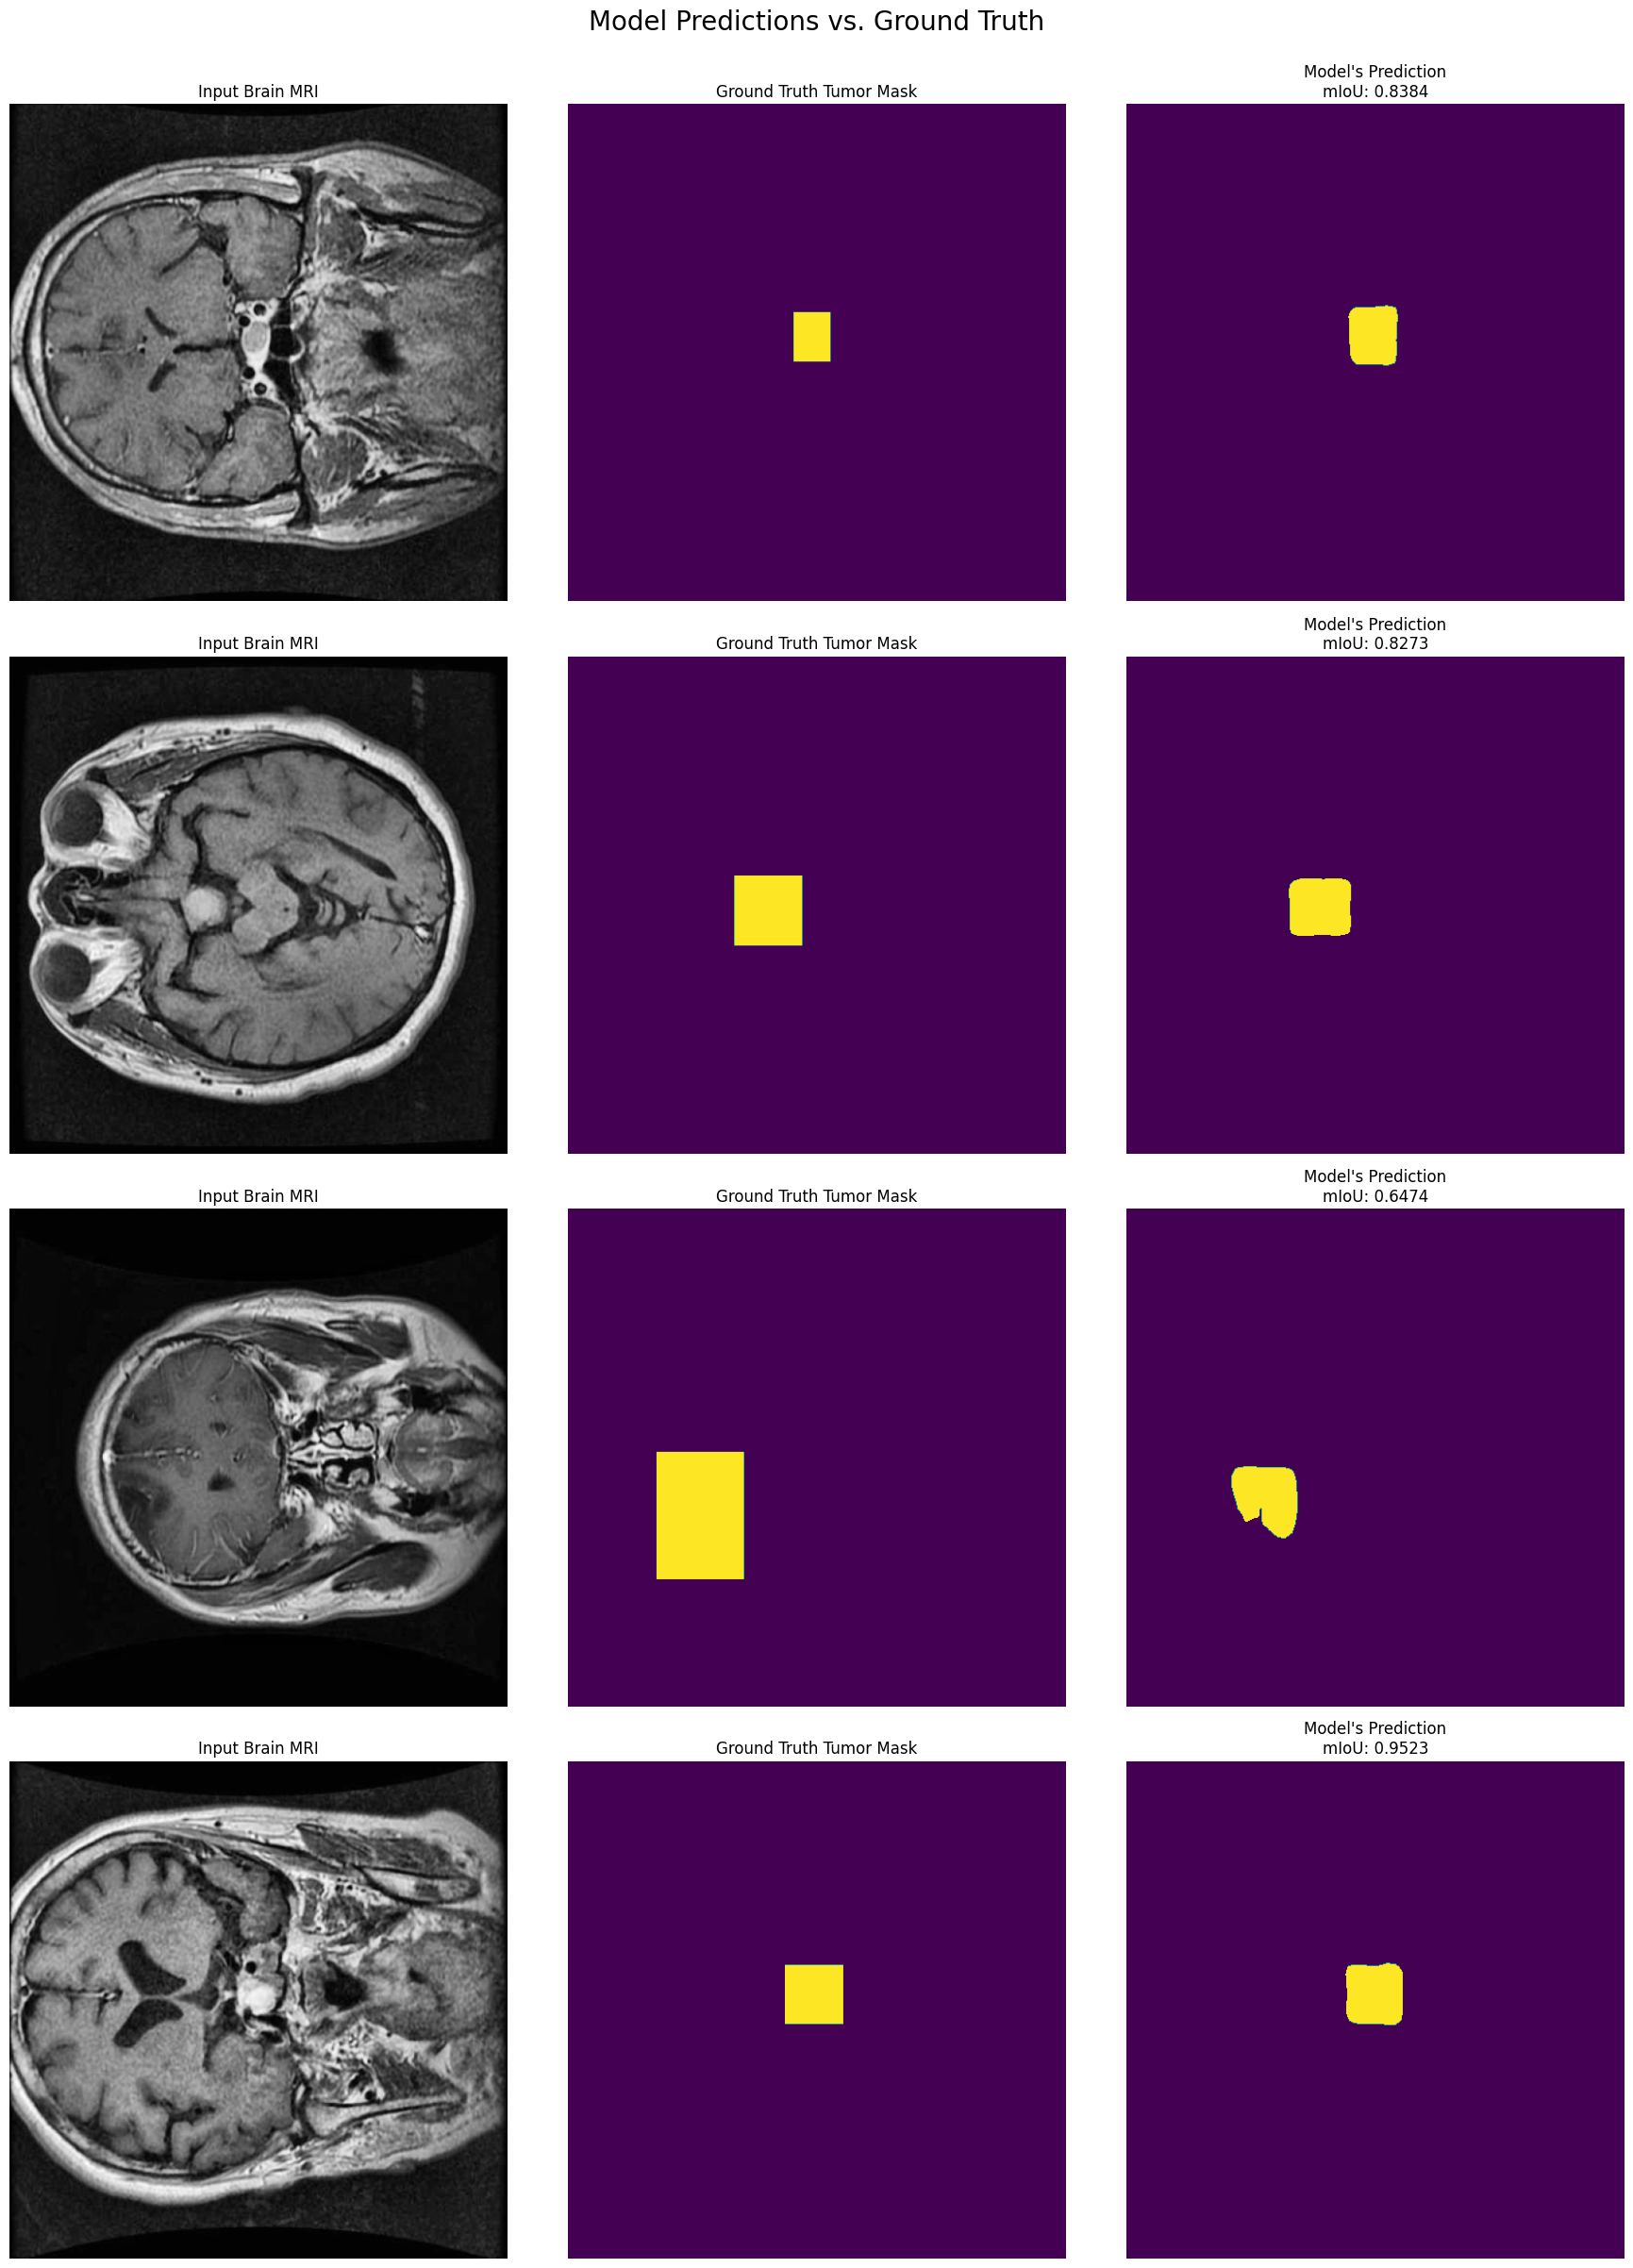

In [10]:
# =====================================================================================
#  Block 7: Inference and Visualization on Brain Tumor Data
# =====================================================================================

print("\n--- Preparing for Inference and Visualization on the Brain Tumor dataset ---")
model_path = '/kaggle/input/danet-brain-tumor/pytorch/default/1/danet_best_model_brain_tumor.pth'

# First, check if the trained model file actually exists from the previous step.
if not os.path.exists(model_path):
    print("="*50)
    print(f"ERROR: Model file not found at '{model_path}'")
    print("Please ensure you have successfully run the training block (Block 6) to generate the model file.")
    print("="*50)
else:
    # --- Step 1: Instantiate a new model and load the saved weights ---
    # We set pretrained_base=False because we are loading our own fine-tuned weights, not ImageNet weights.
    inference_model = DANet(num_classes=NUM_CLASSES, pretrained_base=False).to(device)
    inference_model.load_state_dict(torch.load(model_path))
    
    # --- Step 2: Set the model to evaluation mode (CRITICAL) ---
    inference_model.eval()
    print(f"Successfully loaded best model weights from '{model_path}'.")

    # --- Step 3: Get a batch of data from the validation loader ---
    print("\nFetching a batch of validation data to test...")
    test_images, ground_truth_masks = next(iter(val_loader))

    # --- Step 4: Perform Inference within a torch.no_grad() context for efficiency ---
    with torch.no_grad():
        # Move images to the GPU
        test_images_device = test_images.to(device)
        # Get model outputs
        outputs = inference_model(test_images_device)
        # Get the predicted class for each pixel and move to CPU
        predictions = torch.argmax(outputs, 1).cpu()

    print("Inference complete. Visualizing results...")

    # --- Step 5: Visualize the Results ---
    num_samples_to_show = min(len(test_images), 4) # Show up to 4 samples
    plt.figure(figsize=(18, 6 * num_samples_to_show))
    plt.suptitle("Model Predictions vs. Ground Truth", fontsize=20, y=1.0)

    for i in range(num_samples_to_show):
        # Prepare the images and masks for plotting
        img_display = unnormalize(test_images[i].cpu(), IMG_MEAN, IMG_STD).permute(1, 2, 0).numpy()
        gt_mask_display = ground_truth_masks[i].numpy()
        pred_mask_display = predictions[i].numpy()
        
        # Calculate the mIoU for this specific image to display in the title
        iou_score = mIoU(outputs[i].unsqueeze(0).cpu(), ground_truth_masks[i].unsqueeze(0))
        
        # Plot Input Image
        plt.subplot(num_samples_to_show, 3, i * 3 + 1)
        plt.imshow(np.clip(img_display, 0, 1))
        plt.title("Input Brain MRI")
        plt.axis('off')
        
        # Plot Ground Truth Mask
        plt.subplot(num_samples_to_show, 3, i * 3 + 2)
        plt.imshow(gt_mask_display, cmap='viridis')
        plt.title("Ground Truth Tumor Mask")
        plt.axis('off')
        
        # Plot Model's Prediction
        plt.subplot(num_samples_to_show, 3, i * 3 + 3)
        plt.imshow(pred_mask_display, cmap='viridis')
        plt.title(f"Model's Prediction\nmIoU: {iou_score:.4f}")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()